# For Alyson

In [1]:
import os
from annotator_metrics.src.preprocessing import follow_symlinks

pred_seg_path = "/groups/cellmap/cellmap/ackermand/forDavis/renumbered"
input_base_path = "/groups/cellmap/cellmap/ackermand/annotation_and_analytics/include_predictions/data/"
df_row_values = []
from annotator_metrics.util.doc_util import MaskInformation
mi = MaskInformation()
for row in mi.rows:
    if row.group != "group7":
        all_segmentations = os.listdir(f"{input_base_path}/{row.group}/{row.crop}")
        original_segmentation_types = [n.split(".")[0] for n in all_segmentations]
        original_image_paths = [
            f"{input_base_path}/{row.group}/{row.crop}/{f}" for f in all_segmentations
        ]
        for organelle_name, organelle_label in row.organelle_info.items():
            image_paths = []
            segmentation_types = []
            for idx, p in enumerate(original_image_paths):
                use_image = True
                if "ariadne" in p and organelle_name != "mito":
                    use_image = False
                if original_segmentation_types[idx] in ["predictions", "refinements"]:
                    if original_segmentation_types[idx] == "predictions":
                        annotation_type = "pred"
                    else:
                        annotation_type = "seg"
                    # for things with lumen, we use the base class and label everything else, lumen being what is left behind
                    # for things with in, we use the base class and label out, in being what is left behind
                    is_lumen = False
                    is_in = False
                    if "-lum" in organelle_name:
                        adjusted_name = organelle_name.split("-lum")[0]
                        is_lumen = True
                    elif "-in" in organelle_name:
                        adjusted_name = organelle_name.split("-in")[0]
                        is_in = True
                    else:
                        adjusted_name = organelle_name

                    path = f"{pred_seg_path}/{row.cell_name}/{row.cell_name}.n5/{adjusted_name}"
                    if not os.path.exists(follow_symlinks(f"{path}_{annotation_type}")):
                        use_image = False
                    elif is_lumen and not os.path.exists(
                        follow_symlinks(f"{path}-mem_{annotation_type}")
                    ):
                        # can only calculate lumen if we have a mem
                        use_image = False
                    elif is_in and not os.path.exists(
                        follow_symlinks(f"{path}-out_{annotation_type}")
                    ):
                        # can only calculate inner part if we have an outer part
                        use_image = False
                    if not use_image:
                        if annotation_type == "pred":
                            print(row.group,row.crop,row.cell_name,organelle_name,annotation_type)

group1 09 jrc_mus-liver mito-ribo pred
group2 01 jrc_hela-2 eres-mem pred
group2 01 jrc_hela-2 eres-lum pred
group2 03 jrc_hela-2 eres-mem pred
group2 03 jrc_hela-2 eres-lum pred
group2 04 jrc_hela-2 eres-mem pred
group2 04 jrc_hela-2 eres-lum pred
group2 06 jrc_jurkat-1 eres-mem pred
group2 06 jrc_jurkat-1 eres-lum pred
group3 06 jrc_mus-liver endo-mem pred
group3 06 jrc_mus-liver endo-lum pred
group4 09 jrc_macrophage-2 mt-in pred
group4 09 jrc_macrophage-2 mt-out pred
group4 10 jrc_macrophage-2 mt-in pred
group4 10 jrc_macrophage-2 mt-out pred
group5 02 jrc_hela-3 hchrom pred
group5 02 jrc_hela-3 echrom pred
group5 02 jrc_hela-3 nucleoplasm pred
group5 03 jrc_hela-3 hchrom pred
group5 03 jrc_hela-3 nucleoplasm pred
group5 08 jrc_hela-3 hchrom pred
group5 08 jrc_hela-3 echrom pred
group5 08 jrc_hela-3 nucleoplasm pred
group5 09 jrc_hela-2 echrom pred
group5 09 jrc_hela-2 nechrom pred
group5 09 jrc_hela-2 nucleoplasm pred
group5 10 jrc_hela-2 hchrom pred
group5 10 jrc_hela-2 echrom pr

/groups/scicompsoft/home/ackermand/.local/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
/groups/scicompsoft/home/ackermand/.local/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice


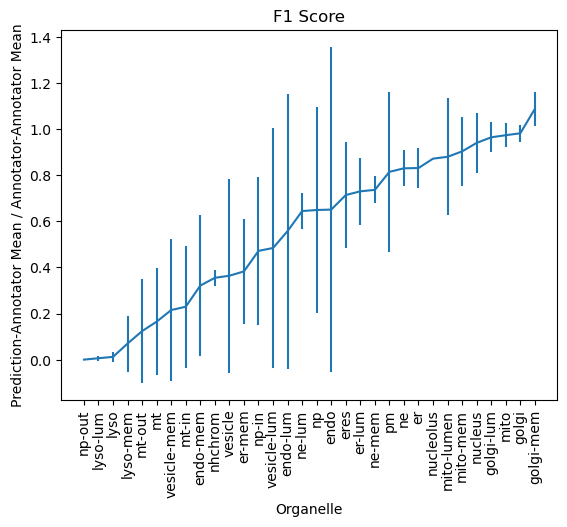

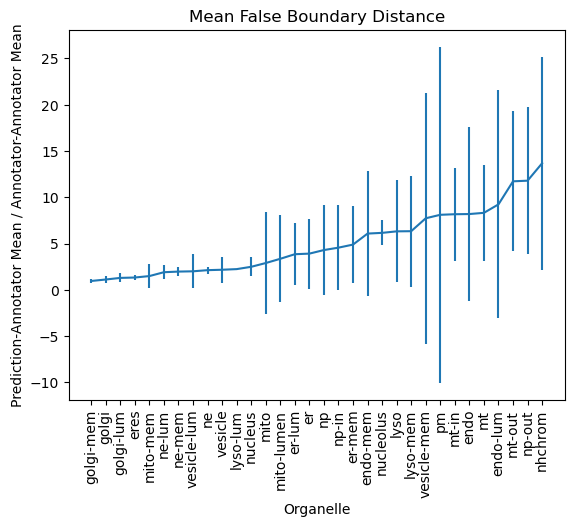

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from CNNectome.validation.organelles.segmentation_metrics import display_name
from annotator_metrics.util.doc_util import MaskInformation
import numpy as np


def consolidate_csvs(dir, metric, skip_duplicates=True, skip_selfself=True):
    output_df = pd.DataFrame(columns=["group", "crop", "organelle", "ratio"])
    mi = MaskInformation()
    for mi_row in mi.rows:
        for organelle in mi_row.organelle_info.keys():
            file_path = f"{dir}/{mi_row.group}/{mi_row.crop}/{metric}/{organelle}.csv"
            if os.path.exists(file_path):
                current_df = pd.read_csv(file_path)
                if skip_duplicates or skip_selfself:
                    df_rows_to_drop = []
                    pairs = []
                    for i, df_row in current_df.iterrows():
                        if (
                            skip_duplicates
                            and (df_row["annotator 2"], df_row["annotator 1"]) in pairs
                        ):
                            df_rows_to_drop.append(i)
                        if (
                            skip_selfself
                            and df_row["annotator 1"] == df_row["annotator 2"]
                        ):
                            df_rows_to_drop.append(i)
                        if df_row["annotator 1"] in [
                            "refinements",
                            "ariadne",
                        ] or df_row["annotator 2"] in ["refinements", "ariadne"]:
                            df_rows_to_drop.append(i)
                        pairs.append((df_row["annotator 1"], df_row["annotator 2"]))
                        if df_row["annotator 2"] == "predictions":
                            current_df.iloc[i] = [
                                df_row["annotator 2"],
                                df_row["annotator 1"],
                                df_row[current_df.columns[2]],
                            ]
                    current_df = current_df.drop(df_rows_to_drop)
                    predictions_df = current_df[
                        (current_df["annotator 1"] == "predictions")
                        | (current_df["annotator 2"] == "predictions")
                    ]
                    annotator_df = current_df[
                        (current_df["annotator 1"] != "predictions")
                        & (current_df["annotator 2"] != "predictions")
                    ]
                    if len(predictions_df) > 0 and len(annotator_df) > 0:
                        dn = display_name(metric)
                        if annotator_df[dn].mean() != 0:
                            ratio = np.nanmean(predictions_df[dn].to_numpy()) / np.nanmean(annotator_df[dn].to_numpy())
                        output_df.loc[len(output_df)] = [
                            mi_row.group,
                            mi_row.crop,
                            organelle,
                            ratio,
                        ]
    return output_df


dir = "/groups/cellmap/cellmap/ackermand/annotation_and_analytics/include_predictions/results/csvs"

scores = [
    "dice",
    "mean_false_bdy_distance",
    # "false_positive_rate",
    # "false_negative_rate",
]
for score in scores:
    all_organelle_df = None
    output_df = consolidate_csvs(dir, score)
    output_df.to_csv(f"/groups/cellmap/cellmap/ackermand/forAlyson/{score}_ratio.csv",index=False)
    grouped_by_organelle = output_df.groupby("organelle")
    avg = grouped_by_organelle.mean()
    std = grouped_by_organelle.std()
    stats_df = pd.DataFrame(
       {
           "organelle": avg.index,
           "ratio mean": avg["ratio"].to_numpy(),
           "ratio std": std["ratio"].to_numpy(),
       }
    ).sort_values(by="ratio mean")
    #stats_df.to_csv(f"{score}_ratio.csv")
    plt.figure()
    plt.errorbar(x=stats_df["organelle"],y=stats_df["ratio mean"],yerr=stats_df["ratio std"])
    plt.title(display_name(score))
    plt.xlabel("Organelle")
    plt.ylabel("Prediction-Annotator Mean / Annotator-Annotator Mean")
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    #all_organelle_df.to_csv(f"my-presentation-stuff/summary-{score}.csv", index=False)


In [39]:
import numpy
class RGB(numpy.ndarray):
  @classmethod
  def from_str(cls, rgbstr):
    return numpy.array([
      int(rgbstr[i:i+2], 16)
      for i in range(1, len(rgbstr), 2)
    ]).view(cls)
 
  def __str__(self):
    self = self.astype(numpy.uint8)
    return '#' + ''.join(format(n, 'x') for n in self)
 
c1 = RGB.from_str('#E5D6FF')
print(c1)
c2 = RGB.from_str('#33005F')
print(c1-c2+RGB.from_str('#9A7900'))

print((c1 + c2) / 2)

np.array(hex_to_rgb("#E5D6FF"))-np.array(hex_to_rgb('#33005F'))+hex_to_rgb('#9A7900')
print(np.linalg.norm(np.array(hex_to_rgb("#E5D6FF"))-np.array(hex_to_rgb('#33005F'))),np.linalg.norm(np.array(hex_to_rgb('#FFEA35'))-np.array(hex_to_rgb('#9A7900'))))

#e5d6ff
#4c4fa0
#8c6baf
321.0607419165414 160.5584005899411


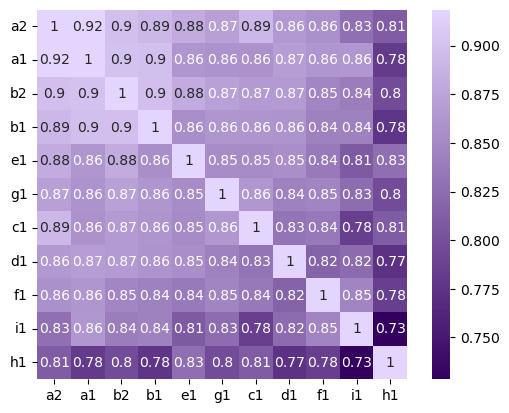

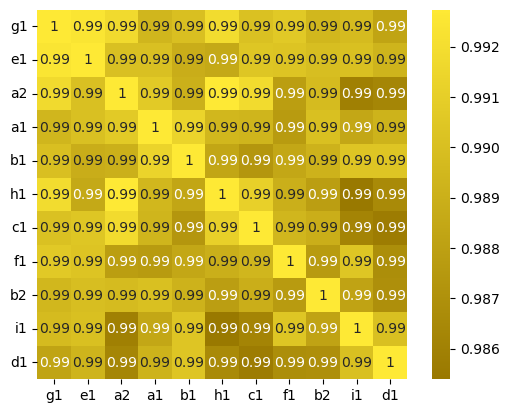

In [25]:
from webbrowser import get
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import matplotlib
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = matplotlib.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

def get_all_to_all(df):
    df = df[~(df["annotator 1"].isin(["predictions","refinements","ariadne"])) & ~(df["annotator 2"].isin(["predictions","refinements","ariadne"]))]
    df = df.replace("gt","h1")
    annotators = df["annotator 1"].unique()
    all_to_all = np.zeros(shape=(len(annotators),len(annotators)))
    annotator_idx = list(range(len(annotators)))
    for i in annotator_idx:
        for j in annotator_idx:
            all_to_all[i,j] = df[(df["annotator 1"]==annotators[i]) & (df["annotator 2"]==annotators[j])]["F1 Score"]
    sort_order = np.argsort(np.nanmean(all_to_all, axis=0))[::-1]
    all_to_all = all_to_all[:, sort_order]
    all_to_all = all_to_all[sort_order, :]
    return annotators[sort_order],all_to_all
       
do_standard = False
if do_standard:
    vmax=-1E6
    vmin=1E6
    for organelle in ["mito-mem","mito"]:
        df = pd.read_csv(f"/groups/cellmap/cellmap/ackermand/annotation_and_analytics/include_predictions/results/csvs/group1/01/dice/{organelle}.csv")
        #print(np.amax(all_to_all[all_to_all!=1.0]))
        annotators,all_to_all = get_all_to_all(df)
        mask = np.ones(all_to_all.shape, dtype=bool)
        current_max = all_to_all[mask].max()
        current_min = all_to_all[mask].min()
        if current_max > vmax:
            vmax = current_max
        if current_min < vmin:
            vmin = current_min


for organelle in ["mito-mem","mito"]:
    df = pd.read_csv(f"/groups/cellmap/cellmap/ackermand/annotation_and_analytics/include_predictions/results/csvs/group1/01/dice/{organelle}.csv")
    #print(np.amax(all_to_all[all_to_all!=1.0]))
    annotators,all_to_all = get_all_to_all(df)
    mask = np.ones(all_to_all.shape, dtype=bool)
    np.fill_diagonal(mask, 0)
    plt.figure()
    if not do_standard:
        vmin = all_to_all[mask].min()
        vmax = all_to_all[mask].max()
    
    if organelle=="mito":
        cmap = get_continuous_cmap(['9A7900','FFEA35'])
    elif organelle=="mito-mem":
        cmap = get_continuous_cmap(['33005F','E5D6FF'])

    seaborn.heatmap(
                all_to_all,
                annot=True,
                square=True,
                vmin=vmin,#0.775,#score_range_min,
                vmax=vmax,#all_to_all[mask].max(),#score_range_max,
               cmap=cmap,#"cool",
            )
    plt.xticks(
                [i + 0.5 for i in range(len(annotators))],
                annotators,
                rotation=0,
                #ha="left",
            )
    plt.yticks(
        [i + 0.5 for i in range(len(annotators))],
        annotators,
        rotation=0,
    )
    if do_standard:
        plt.savefig(f'/groups/cellmap/cellmap/ackermand/forAlyson/{organelle}_f1_score_standard_nonselfselfmax.svg')
    else:
        plt.savefig(f'/groups/cellmap/cellmap/ackermand/forAlyson/{organelle}_f1_score_nonstandard_nonselfselfmax.svg')
        


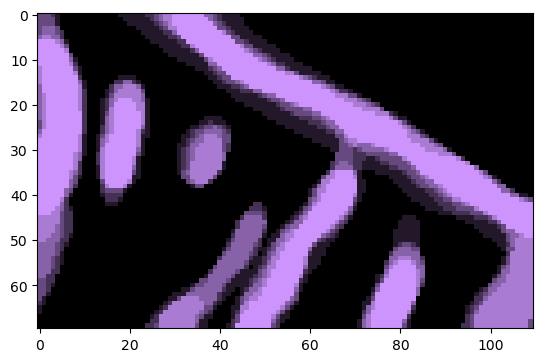

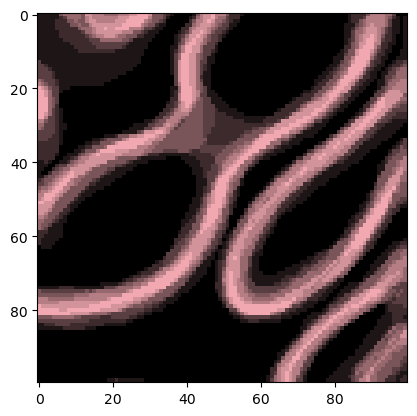

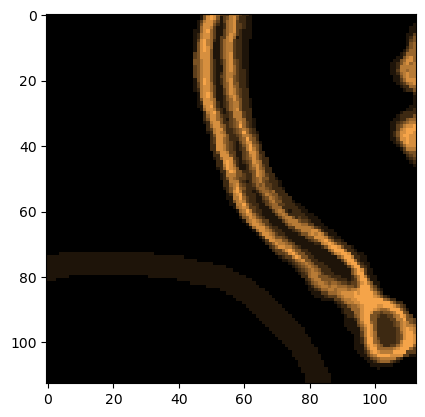

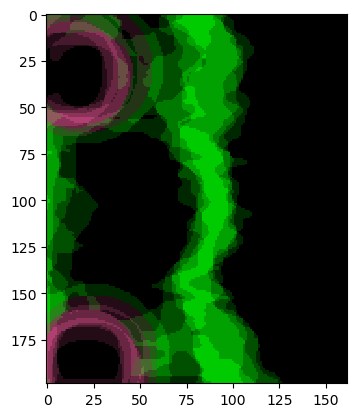

In [4]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

plotting_dict = {
    "group1/09/": {
        "organelles": {
            "mito-mem": {"label": 3, "rgb": np.array((205, 148, 254), dtype=np.uint8)}
        },
        "slice": np.s_[139, :, :, :],
    },
    "group2/05/": {
        "organelles": {
            "golgi-mem": {
                "label": 6,
                "rgb": np.array((242, 168, 176), dtype=np.uint8),
            }
        },
        "slice": np.s_[10, :, :, :],
    },
    "group2/12/": {
        "organelles": {
            "er-mem": {"label": 16, "rgb": np.array((245, 164, 73), dtype=np.uint8)}
        },
        "slice": np.s_[8, :, :, :],
    },
    "group5/15/": {
        "organelles": {
            "ne-mem": {"label": 20, "rgb": np.array((0, 202, 0), dtype=np.uint8)},
            "np-out": {"label": 22, "rgb": np.array((176, 64, 113), dtype=np.uint8)},
        },
        "slice": np.s_[:, 30, :, :],
    },
}
# plotting_dict = {"group1/01/": {4: np.array((154, 121, 0), dtype=np.uint8), 3: np.array((229, 214, 255),dtype=np.uint8) }}
base_dir = "/groups/cellmap/cellmap/ackermand/annotation_and_analytics/include_predictions/data/"
for crop, info in plotting_dict.items():
    im_rgb = None
    im_rwb = None
    file_names = os.listdir(base_dir + crop)
    file_names = [
        file_name
        for file_name in file_names
        if not file_name.startswith(("predictions", "refinements", "ariadne"))
    ]
    for file_name in file_names:
        file_name = base_dir + crop + file_name
        im = tifffile.imread(file_name)
        current_im_rgb = 0 * 255 * np.ones((*im.shape, 3))
        for organelle_dict in info["organelles"].values():
            mask = im == organelle_dict["label"]
            current_im_rgb[mask, :] = organelle_dict["rgb"]
            label = organelle_dict["label"]
        if im_rgb is None:
            im_rwb = 1.0 * (im == label)
            im_rgb = current_im_rgb
        else:
            im_rwb += 1.0 * (im == label)
            im_rgb += current_im_rgb

#print(np.amax(im_rwb[1, :, :] / (len(file_names))))
    plt.figure()
    plt.imshow(
        (im_rgb[info["slice"]] / (len(file_names))).astype(np.uint8), interpolation="none"
    )
    organelles = '_'.join(list(info["organelles"].keys()))
    crop = crop.replace("/","_")
    #plt.savefig(f"/groups/cellmap/cellmap/ackermand/forAlyson/{crop}_{organelles}.png",dpi=300)
    #tifffile.imwrite(f"/groups/cellmap/cellmap/ackermand/forAlyson/{crop}_{organelles}.tif",(im_rgb[info["slice"]] / (len(file_names))).astype(np.uint8))
    im = Image.fromarray((im_rgb[info["slice"]] / (len(file_names))).astype(np.uint8))
    im.save(f'/groups/cellmap/cellmap/ackermand/forAlyson/{crop}_{organelles}.tif')
    #plt.imshow(im_rwb[info["slice"]]/len(file_names),cmap="bwr",interpolation='none')
    
# print(len(file_names),np.amax(np.asarray(im_rgba)[...,3]),np.amax(np.asarray(current_im_rgba)[...,3]))


<a list of 41 text.Text objects>

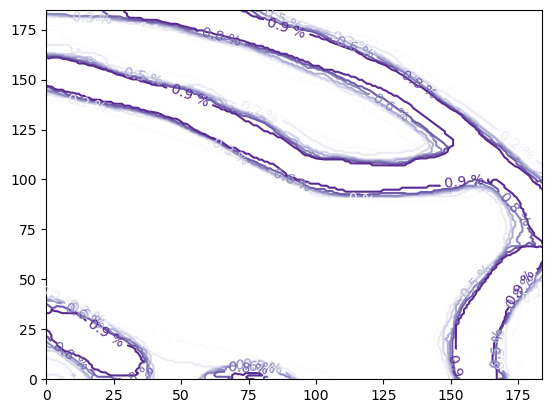

In [76]:
# This custom formatter removes trailing zeros, e.g. "1.0" becomes "1", and
# then adds a percent sign.
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s} %"

ax = plt.gca()
#ax.imshow((im_rgb[info["slice"]]/len(file_names)).astype(np.uint8),cmap="Purples")
#ax.contourf(im_rwb[1,:,:]/len(file_names),cmap="Purples")#,alpha=1.0)
CS = ax.contour(im_rwb[1,:,:]/len(file_names),cmap="Purples",alpha=1.0)
ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)


# Plot 1: Annotator-annotator averages vs Annotator-prediction averages


In [2]:
from annotator_metrics.util.doc_util import MaskInformation
import pandas as pd
from os.path import exists
import numpy as np
from CNNectome.validation.organelles.segmentation_metrics import display_name

metric = "dice"  # "mean_false_bdy_distance"
metric_name = display_name(metric)
mi = MaskInformation()
dfs = []
excluding = ["ariadne", "refinements"]
combined_df = pd.DataFrame(
    columns=[
        "group",
        "crop",
        "organelle",
        "annotator mean",
        "annotator std",
        "prediction mean",
        "prediction std",
    ]
)

organelles_of_interest = {
    "mito": (229, 221, 49),
    "nucleus": (142, 58, 112),
    "endo": (0, 160, 255),
    "lyso": (251, 111, 111),
    "golgi": (2, 252, 221),
    "ne": (0, 98, 0),
    "er": (0, 0, 255),
    "eres": (255, 68, 171),
    "mito-mem": (186, 117, 255),
    "pm": (255, 0, 0),
    "lyso-mem": (112, 106, 14),
    "vesicle": (64, 64, 64),
    "mt": (91, 118, 163),
    "endo-mem": (139, 82, 145),
    "np": (64, 78, 122),
    "ne-mem": (0, 149, 0),
    "eres-mem": (135, 3, 3),
    "golgi-mem": (223, 130, 139),
    "er-mem": (186, 89, 30),
    "mt-out": (230, 175, 45),
    "vesicle-mem": (157, 60, 255),
    "np-out": (194, 60, 94),
}

for row in mi.rows:
    group = row.group
    crop = row.crop
    organelles = list(row.organelle_info.keys())
    # print(group, crop, organelles)
    for organelle in organelles:
        if organelle in list(organelles_of_interest.keys()):
            file_name = f"/groups/cellmap/cellmap/ackermand/annotation_and_analytics/include_predictions/results/csvs/{group}/{crop}/{metric}/{organelle}.csv"
            if exists(file_name):
                df = pd.read_csv(file_name)
                if ((df["annotator 1"] == "predictions")).any():  # has predictions
                    print(group,crop,organelle)
                    df = df.drop(
                        df[
                            (df["annotator 1"].isin(excluding))
                            | (df["annotator 2"].isin(excluding))
                            | (df["annotator 1"] == df["annotator 2"])
                        ].index
                    )
                    df_annotators = df[
                        (df["annotator 1"] != "predictions")
                        & (df["annotator 2"] != "predictions")
                    ]
                    df_predictions = df[
                        (df["annotator 1"] == "predictions")
                        | (df["annotator 2"] == "predictions")
                    ]
                    annotators_scores = df_annotators[metric_name]
                    predictions_scores = df_predictions[metric_name]
                    combined_df.loc[len(combined_df.index)] = [
                        group,
                        crop,
                        organelle,
                        np.nanmean(annotators_scores),
                        np.nanstd(annotators_scores),
                        np.nanmean(predictions_scores),
                        np.nanstd(predictions_scores),
                    ]
combined_df = combined_df.dropna()

group1 03 mito-mem
group1 03 mito
group1 09 mito-mem
group1 09 mito
group2 02 er-mem
group2 02 er
group2 05 golgi-mem
group2 05 golgi
group3 01 pm
group3 02 pm
group3 04 pm
group3 04 vesicle-mem
group3 04 vesicle
group3 07 endo-mem
group3 07 vesicle-mem
group3 07 vesicle
group3 07 endo
group3 09 pm
group3 09 endo-mem
group3 09 vesicle-mem
group3 09 lyso-mem
group3 09 vesicle
group3 09 endo
group3 09 lyso
group3 10 pm
group3 10 endo-mem
group3 10 vesicle-mem
group3 10 lyso-mem
group3 10 vesicle
group3 10 endo
group3 10 lyso
group4 04 mt-out
group4 04 mt
group4 09 mt
group4 10 mt
group6 02 mito-mem
group6 02 er-mem
group6 02 pm
group6 02 endo-mem
group6 02 vesicle-mem
group6 02 mt-out
group6 02 mito
group6 02 er
group6 02 vesicle
group6 02 endo
group6 02 mt
group6 07 mito-mem
group6 07 er-mem
group6 07 lyso-mem
group6 07 mt-out
group6 07 mito
group6 07 er
group6 07 lyso
group6 07 mt
group6 10 er-mem
group6 10 pm
group6 10 vesicle-mem
group6 10 er
group6 10 vesicle
group6 10 mt
group1 13 

/groups/scicompsoft/home/ackermand/.local/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: Mean of empty slice
/groups/scicompsoft/home/ackermand/miniconda3/envs/annotator-metrics/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


group2 13 er-mem
group2 13 er
group2 14 er-mem
group2 14 er
group5 11 ne-mem
group5 11 nucleus
group5 11 ne
group5 12 ne-mem
group5 12 ne
group5 13 ne-mem
group5 13 nucleus
group5 13 ne


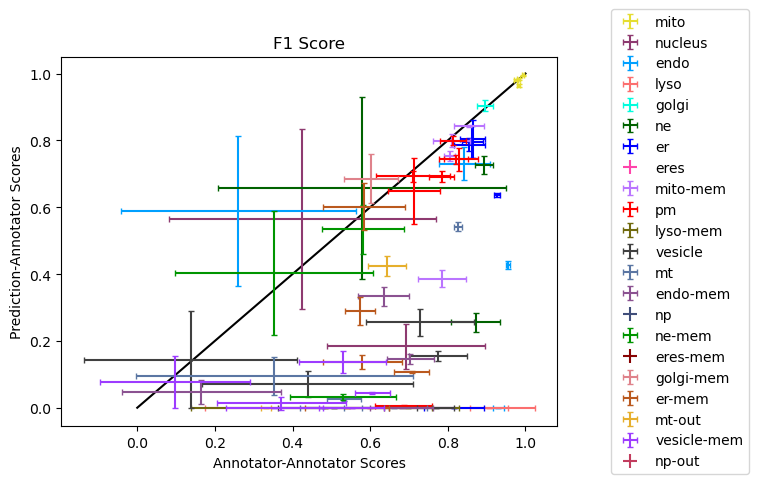

In [3]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
fig,(ax) = plt.subplots(1,1)
plt.plot([0,1],[0,1],color="black")
for organelle,color in organelles_of_interest.items():
    current_df = combined_df[combined_df["organelle"]==organelle]
    plt.errorbar(x=current_df["annotator mean"],y=current_df["prediction mean"],xerr=current_df["annotator std"],yerr=current_df["prediction std"],fmt = '.',capsize=2,color=np.array(color)/255.0, markersize=0,label=organelle)
plt.xlabel("Annotator-Annotator Scores")
plt.ylabel("Prediction-Annotator Scores")
plt.title(metric_name)
ax.legend(loc='center right', numpoints=1,bbox_to_anchor=(1.4, 0.5))

group crop    organelle  annotator mean  annotator std  prediction mean  \
16  group3   07         endo        0.956095       0.005254         0.426291   
44  group6   02         endo        0.260100       0.302812         0.588592   
22  group3   09         endo        0.842748       0.065151         0.730304   
29  group3   10         endo        0.929737       0.013833         0.000006   
25  group3   10     endo-mem        0.681682       0.081124         0.000014   
18  group3   09     endo-mem        0.634955       0.065574         0.332870   
13  group3   07     endo-mem        0.703169       0.060822         0.145805   
38  group6   02     endo-mem        0.164835       0.204361         0.047344   
57  group6   10           er        0.926113       0.007685         0.636959   
65  group2   14           er        0.814682       0.077272         0.000021   
63  group2   13           er        0.864345       0.032127         0.804032   
42  group6   02           er        0.863257       0.026817         0.794275   
5   group2   02           er        0.854719       0.039808         0.787302   
64  group2   14       er-mem        0.541418       0.108245         0.000002   
62  group2   13       er-mem        0.583752       0.105184         0.601387   
54  group6   10       er-mem        0.707106       0.044648         0.106813   
36  group6   02       er-mem        0.573879       0.039765         0.290087   
4   group2   02       er-mem        0.579712       0.101282         0.136285   
7   group2   05        golgi        0.896020       0.019771         0.903389   
6   group2   05    golgi-mem        0.602397       0.069311         0.685557   
30  group3   10         lyso        0.906302       0.049909         0.000000   
23  group3   09         lyso        0.599806       0.424355         0.000000   
20  group3   09     lyso-mem        0.483349       0.345938         0.000000   
27  group3   10     lyso-mem        0.697733       0.062439         0.000000   
41  group6   02         mito        0.975259       0.004743         0.979749   
3   group1   09         mito        0.982175       0.003467         0.984012   
61  group1   13         mito        0.993018       0.002420         0.994246   
1   group1   03         mito        0.982122       0.003765         0.964750   
0   group1   03     mito-mem        0.785173       0.060991         0.386072   
60  group1   13     mito-mem        0.809604       0.047642         0.798855   
2   group1   09     mito-mem        0.853799       0.038942         0.843831   
35  group6   02     mito-mem        0.805005       0.013720         0.754044   
59  group6   10           mt        0.353350       0.357103         0.095622   
45  group6   02           mt        0.533512       0.043583         0.024796   
32  group4   04           mt        0.826337       0.010939         0.541500   
33  group4   09           mt        0.476132       0.055991         0.000000   
34  group4   10           mt        0.662401       0.082983         0.000000   
31  group4   04       mt-out        0.644340       0.048884         0.424023   
40  group6   02       mt-out        0.332047       0.013532         0.000096   
70  group5   12           ne        0.893006       0.022263         0.726909   
68  group5   11           ne        0.871850       0.062846         0.255894   
73  group5   13           ne        0.579382       0.370756         0.658010   
71  group5   13       ne-mem        0.351424       0.254873         0.403300   
69  group5   12       ne-mem        0.581847       0.104963         0.533832   
66  group5   11       ne-mem        0.530259       0.136227         0.032070   
72  group5   13      nucleus        0.425163       0.344462         0.564459   
67  group5   11      nucleus        0.692478       0.204045         0.184021   
24  group3   10           pm        0.686796       0.073216         0.006397   
55  group6   10           pm        0.820336       0.030543         0.742883   
37  g

lyso
golgi
eres
lyso-mem
np
eres-mem
golgi-mem
np-out


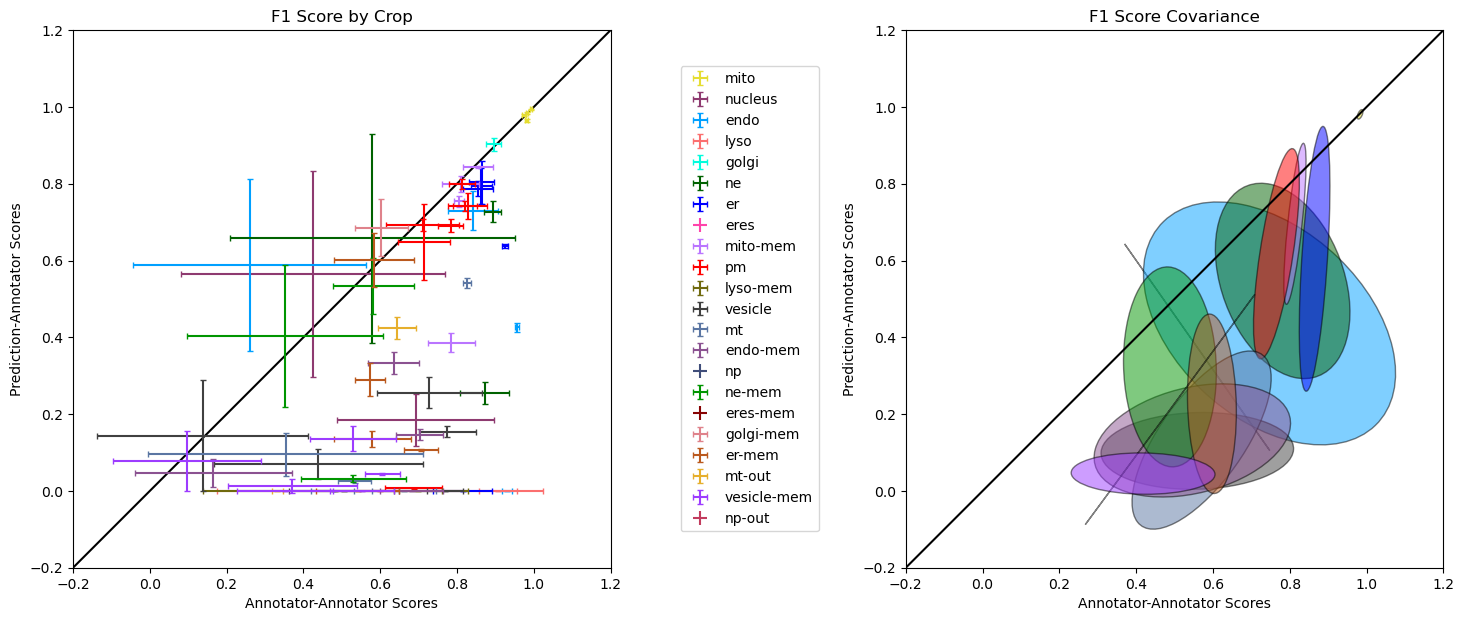

In [24]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
    
    cov = np.cov(x, y)
    delta_x = x-np.mean(x)
    delta_y = y-np.mean(y)
    #my_pearson = np.sum(np.multiply(delta_x,delta_y))/np.multiply(np.sqrt(np.sum(np.power(delta_x,2))),np.sqrt(np.sum(np.power(delta_y,2))))
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    if pearson<-1.0:
        pearson=-1.0
    if pearson>1.0:
        pearson=1.0
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

fig = plt.figure(figsize=(15, 10))
axs = [None,None]
axs[0] = plt.subplot(121, aspect='equal')
axs[1] = plt.subplot(122, aspect='equal',sharey=axs[0])
min_ = -.2
max_ = 1.2
for i in range(2):
    axs[i].plot([min_,max_],[min_,max_],color="black")
    axs[i].set_xlabel("Annotator-Annotator Scores")
    axs[i].set_ylabel("Prediction-Annotator Scores")
    axs[i].set_xlim([-.2,1.2])
    axs[i].set_ylim([-.2,1.2])

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(combined_df.sort_values(["organelle"]))

for organelle,color in organelles_of_interest.items():
    current_df = combined_df[combined_df["organelle"]==organelle]
    axs[0].errorbar(x=current_df["annotator mean"],y=current_df["prediction mean"],xerr=current_df["annotator std"],yerr=current_df["prediction std"],fmt = '.',capsize=2,color=np.array(color)/255.0, markersize=0,label=organelle)
axs[0].legend(loc='center right', numpoints=1,bbox_to_anchor=(1.4, 0.5))
axs[0].set_title(f"{metric_name} by Crop")

for organelle,color in organelles_of_interest.items():
    current_df = combined_df[combined_df["organelle"]==organelle]
    x= current_df["annotator mean"].to_numpy()
    y = current_df["prediction mean"].to_numpy()
    if len(x) > 1 and np.any(y>0):
        confidence_ellipse(x, y, axs[1],
                        alpha=0.5, facecolor=np.array(color)/255.0, n_std=1, edgecolor='black', zorder=0) 
    else:
        print(organelle)
axs[i].set_title(f"{metric_name} Covariance")    
fig.tight_layout(pad=2.0)


In [25]:
print(len(x))

0


In [145]:
a=np.array([[0,2],[3,4],[5,6]])
b=a[:,1]
b.shape

(3,)

# Voxel intensity distributions for agreements and disagreements just for mito


In [ ]:
# voxel distribution for disagreements
from annotator_metrics.util.doc_util import MaskInformation
mi = MaskInformation()

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import zarr

row = mi.rows[0]
input_path = f'/groups/cellmap/cellmap/ackermand/annotation_and_analytics/include_predictions/results/n5s/{row.group}/{row.crop}.n5'
image_names = [i for i in os.listdir(input_path) if ("attributes" not in i and "variance" not in i and "raw" not in i and "predictions" not in i and "refinements" not in i)]
images = []
def get_positive_label_mask(image, organelle_label):
    if type(organelle_label) == list:
        positive_label_mask = np.zeros(image.shape, dtype=bool)
        for current_organelle_label in organelle_label:
            positive_label_mask |= image == current_organelle_label
    else:
        positive_label_mask = image == organelle_label
    return positive_label_mask

zarr_file = zarr.open(input_path, mode="r")
im_raw = zarr_file["raw"][:][:][:]
for image_name in image_names:
    current_image = zarr_file[image_name][:][:][:]
    if "predictions" in image_name:
        prediction = current_image
    elif not any(s in image_name for s in ["ariadne", "refinements"]):
        images.append(current_image)

step = 2
legend = []
for image_name in image_names:
    legend.append(image_name)
    legend.append(f'_{image_name}')

num_organelles = len(row.organelle_info.items())
plt.rcParams['font.size'] = '14'
fig, axs = plt.subplots(num_organelles, 2, sharex=True, sharey="row", figsize=(10,15), dpi=300)
idx = 0
for organelle_name, organelle_label in row.organelle_info.items():
    
    ax = plt.gca()
    masks = []
    min_bin = 256
    max_bin = 0
    for i,image in enumerate(images):
        mask = get_positive_label_mask(image, organelle_label)
        masks.append(mask)
        #if type(organelle_label) != list:
        vals, bins = np.histogram(im_raw[mask], bins=np.arange(start=0, stop=256, step=step))#, density=True)
        nonzeros = vals.nonzero()[0]
        min_bin = min(min_bin, bins[nonzeros[0]])
        max_bin = max(max_bin, bins[nonzeros[-1]])
        print(legend[i*2],organelle_name, np.mean(im_raw[mask]),np.std(im_raw[mask]), min_bin, max_bin)
        color = next(axs[idx,0]._get_lines.prop_cycler)['color']
        axs[idx,0].plot(np.arange(step/2, 255, step), vals, color=color)
        axs[idx,0].axvline(x = np.mean(im_raw[mask]), color=color, label = 'axvline - full height',linewidth=1.0, zorder=0,alpha=1.0)
    if idx==0:
        axs[idx,0].set_title("All")
    elif idx==num_organelles-1:
        axs[idx,0].set_xlabel("Raw Intensities")
    #axs[idx,0].set_xlabel("raw value")
    axs[idx,0].set_ylabel(f"{organelle_name} Voxel Counts")
    axs[idx,0].set_xlim(min_bin-step,max_bin+step)
    legend = [l if l!="gt" else "j1" for l in legend]
    #axs[idx,0].legend(legend)

    min_bin = 256
    max_bin = 0
    masks_sum = np.sum(masks, axis=0)
    num_annotations = len(images)
    for i,mask in enumerate(masks):
        # only get infor for voxels that have some disagreement
        vals, bins = np.histogram(im_raw[(mask>0) & (masks_sum!=num_annotations)], bins=np.arange(start=0, stop=256, step=step))#, density=True)
        nonzeros = vals.nonzero()[0]
        min_bin = min(min_bin, bins[nonzeros[0]])
        max_bin = max(max_bin, bins[nonzeros[-1]])
        color = next(axs[idx,1]._get_lines.prop_cycler)['color']
        print(legend[i*2],organelle_name, np.mean(im_raw[(mask>0) & (masks_sum!=num_annotations)]), min_bin, max_bin)
        axs[idx,1].plot(np.arange(step/2, 255, step), vals, color=color)
        axs[idx,1].axvline(x = np.mean(im_raw[(mask>0) & (masks_sum!=num_annotations)]), color=color, label = 'axvline - full height',linewidth=1.0, zorder=0,alpha=1.0)
    if idx==0:
        axs[idx,1].set_title("Disagreement")
    elif idx==num_organelles-1:
        axs[idx,1].set_xlabel("Raw Intensities")
    #axs[idx,1].set_xlabel("raw value")
    #axs[idx,1].set_ylabel("fraction")
    #axs[idx,1].set_title(f"{organelle_name}: Disagreement Voxels")
    axs[idx,1].set_xlim(min_bin-step,max_bin+step)
    legend = [l if l!="gt" else "j1" for l in legend]
    #axs[idx,1].legend(legend)
    idx+=1
plt.subplots_adjust(wspace=0.05, hspace=0.05)



# Collect data for box and whisker plots of intensities (into my-intensities.csv)

In [2]:
# voxel distribution for disagreements
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import zarr
from annotator_metrics.util.doc_util import MaskInformation
import csv

mi = MaskInformation()

with open('my-intensities.csv', 'w') as f:
    
    # create the csv writer
    writer = csv.writer(f)
    writer.writerow(["group","crop","annotator","organelle","all mean","all std","all min_max normalized","all mean_std normalized","disagreement mean","disagreement std","disagreement min_max normalized","disagreement mean_std normalized"])
    for row in mi.rows:
        if row.group != "group7":
            input_path = f'/groups/cellmap/cellmap/ackermand/annotation_and_analytics/include_predictions/results/n5s/{row.group}/{row.crop}.n5'
            image_names = [i for i in os.listdir(input_path) if ("attributes" not in i and "variance" not in i and "raw" not in i)]# and "predictions" not in i and "refinements" not in i)]
            images = []
            def get_positive_label_mask(image, organelle_label):
                if type(organelle_label) == list:
                    positive_label_mask = np.zeros(image.shape, dtype=bool)
                    for current_organelle_label in organelle_label:
                        positive_label_mask |= image == current_organelle_label
                else:
                    positive_label_mask = image == organelle_label
                return positive_label_mask

            zarr_file = zarr.open(input_path, mode="r")
            im_raw = zarr_file["raw"][:][:][:]
            for image_name in image_names:
                current_image = zarr_file[image_name][:][:][:]
                images.append(current_image)

            raw_min = np.amin(im_raw)
            raw_max = np.amax(im_raw)
            raw_mean = np.mean(im_raw)
            raw_std = np.std(im_raw)
            print(row.group, row.crop, raw_min, raw_max)
            for organelle_name, organelle_label in row.organelle_info.items():
                num_annotators = 0
                masks = []
                masks_sum = np.zeros(images[0].shape)
                output_array = [[] for _ in range(len(images))]
                for i,image in enumerate(images):
                    mask = get_positive_label_mask(image, organelle_label)
                    masks.append(mask)
                    #if type(organelle_label) != list:
                    if image_names[i] not in ["predictions","refinements","ariadne"]:
                        num_annotators += 1
                        masks_sum+=mask
                    output_array[i] = [row.group, row.crop, image_names[i], organelle_name, np.mean(im_raw[mask]), np.std(im_raw[mask]), (np.mean(im_raw[mask])-raw_min)/(raw_max-raw_min), (np.mean(im_raw[mask])-raw_mean)/raw_std]
        
                num_annotations = len(images)
                for i,mask in enumerate(masks):
                    disagreement_voxels = im_raw[(mask>0) & (masks_sum!=num_annotators)]
                    output_array[i] += [np.mean(disagreement_voxels), np.std(disagreement_voxels), (np.mean(disagreement_voxels)-raw_min)/(raw_max-raw_min), (np.mean(disagreement_voxels)-raw_mean)/raw_std]
                    #print(image_names[i], np.mean(disagreement_voxels))
                    # only get infor for voxels that have some disagreement
                writer.writerows(output_array)


group1 01 0 255
group1 02 0 255
group1 03 209 234
group1 04 91 191
group1 05 211 237
group1 06 0 255
group1 07 4 199
group1 08 66 163
group1 09 20 184


/groups/scicompsoft/home/ackermand/miniconda3/envs/annotator-metrics/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/groups/scicompsoft/home/ackermand/miniconda3/envs/annotator-metrics/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/groups/scicompsoft/home/ackermand/miniconda3/envs/annotator-metrics/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/groups/scicompsoft/home/ackermand/miniconda3/envs/annotator-metrics/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/groups/scicompsoft/home/ackermand/miniconda3/envs/annotator-metrics/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



group1 10 70 159
group2 01 73 188
group2 02 208 235
group2 03 79 186
group2 04 95 191
group2 05 213 237
group2 06 211 237
group2 07 179 226
group2 08 180 227
group2 09 150 224
group2 10 171 227
group3 01 214 238
group3 02 218 239
group3 03 58 170
group3 04 0 255
group3 05 72 182
group3 06 24 193
group3 07 207 239
group3 08 68 182
group3 09 210 237
group3 10 204 238
group4 01 88 183
group4 02 95 191
group4 03 118 191
group4 04 0 255
group4 05 167 226
group4 06 69 177
group4 07 204 238
group4 08 206 239
group4 09 210 236
group4 10 210 236
group5 01 0 255
group5 02 0 255
group5 03 0 255
group5 04 18 178
group5 05 30 177
group5 06 40 176
group5 07 37 88
group5 08 0 255
group5 09 73 181
group5 10 65 180
group6 01 0 255
group6 02 0 255
group6 03 0 255
group6 04 29 92
group6 05 63 186
group6 06 209 238
group6 07 205 239
group6 08 31 90
group6 09 0 201
group6 10 206 240
full_crop 01 205 239
full_crop 02 0 255
full_crop 03 30 190


FileNotFoundError: [Errno 2] No such file or directory: '/groups/cellmap/cellmap/ackermand/annotation_and_analytics/include_predictions/results/n5s/group1/11.n5'

# Plot my-intensities.csv data showing box and whisker plot of all organelle intensitie distributions, normalized and unnormalized

In [4]:
import plotly.express as px
import plotly.graph_objects as go
import pandas 
df = pandas.read_csv("my-intensities.csv")
fig = go.Figure(layout = go.Layout(yaxis=dict(title='Normalized Intensity (x-µ<sub>raw</sub>)/σ<sub>raw</sub>')) )
annotator_df = df.loc[(df['annotator'] != "predictions") & (df['annotator'] != "refinements") & (df['annotator'] != "ariadne")]# & (df["group"]=="group1") & (df["crop"]==1)]
automated_df = df.loc[(df['annotator'] == "predictions")]
annotator_df = annotator_df[~(annotator_df["organelle"].str.contains('lum')) & ~(annotator_df["organelle"].str.contains('in'))]

annotator_df["sorting"] = annotator_df.groupby(['organelle'])["all mean_std normalized"].transform(lambda x: (x.max() - x.min()))
sorted_df = annotator_df[["organelle","all mean_std normalized","sorting"]].groupby('organelle').median().sort_values(by=['all mean_std normalized'])
fig.add_traces(go.Box(x=annotator_df["organelle"],y=annotator_df["all mean_std normalized"]))
#fig.add_traces(px.strip(automated_df, x="organelle",y="all mean_std normalized", stripmode = 'overlay',color_discrete_sequence=["black"]).data)

fig.update_xaxes(categoryorder='array', categoryarray= sorted_df.index)
fig.update_layout(showlegend=False, width =1000, height = 500)
#fig.update_traces(orientation='h')
#fig.update_yaxes(type='log',tickformat = ".1r")

In [5]:
import plotly.express as px
import plotly.graph_objects as go
import pandas 
df = pandas.read_csv("my-intensities.csv")
fig = go.Figure(layout = go.Layout(yaxis=dict(title="Voxel Intensity")) )
annotator_df = df.loc[(df['annotator'] != "predictions") & (df['annotator'] != "refinements")]# & (df["group"]=="group1") & (df["crop"]==1)]
automated_df = df.loc[(df['annotator'] == "predictions")]

sorted_df = annotator_df[["organelle","all mean"]].groupby('organelle').median().sort_values(by=['all mean'])
print( sorted_df)
fig.add_traces(go.Box(x=annotator_df["organelle"],y=annotator_df["all mean"]))
#fig.add_traces(px.strip(automated_df, x="organelle",y="all mean", stripmode = 'overlay',color_discrete_sequence=["black"]).data)

fig.update_xaxes(categoryorder='array', categoryarray= sorted_df.index)

               all mean
organelle              
hchrom        65.770083
mito-ribo     78.063914
echrom       100.391735
ne-mem       113.339901
ne           116.124271
nhchrom      119.868927
mito-mem     122.201703
np-out       122.864665
nechrom      124.999621
np           128.106454
ne-lum       132.064710
nucleus      135.380713
mito         137.195320
np-in        139.431200
nucleolus    143.523229
eres-mem     144.740295
eres         146.221508
nucleoplasm  147.392313
eres-lum     154.195964
mito-lumen   159.107329
er-mem       178.967408
er           188.485470
vesicle-lum  188.833801
mt-out       190.049212
mt           190.336154
mt-in        191.565134
vesicle      195.650488
er-lum       199.706077
vesicle-mem  201.959672
lyso-lum     220.389663
pm           221.749615
lyso         222.565011
lyso-mem     223.232984
endo-mem     223.468567
golgi-mem    224.649397
golgi        226.634902
endo         226.774317
endo-lum     227.413123
golgi-lum    228.384638


In [ ]:
# confusion matrix, incomplete

input_path = '/groups/cellmap/cellmap/ackermand/annotation_and_analytics/include_predictions/data'
image_names = os.listdir(f"{input_path}/{row.group}/{row.crop}")
images = []
def get_positive_label_mask(image, organelle_label):
    if type(organelle_label) == list:
        positive_label_mask = np.zeros(image.shape, dtype=bool)
        for current_organelle_label in organelle_label:
            positive_label_mask |= image == current_organelle_label
    else:
        positive_label_mask = image == organelle_label
    return positive_label_mask

for image_name in image_names:
    current_image = tifffile.imread(
        f"{input_path}/{row.group}/{row.crop}/{image_name}"
    )
    if "predictions" in image_name:
        prediction = current_image
    elif not any(s in image_name for s in ["ariadne", "refinements"]):
        images.append(current_image)

for i in range(len(images)):
    for j in range(i, len(images)):
        for organelle_name, organelle_label in row.organelle_info.items():
            mask = get_positive_label_mask(images[i], organelle_label)
            if type(organelle_label) != list:
                test_ids, counts = np.unique( np.ma.masked_array(images[j], ~mask), return_counts=True)

                background_count = 0
                for idx, test_id in enumerate(test_ids):
                    if test_id not in row.organelle_info.values() or test_id == 0:
                        background_count += counts(idx)
                output_dict[image_name[i]] = (organelle_name, organelle_name, count)    

                np.unique()

fraction_dict = {}


for organelle_name, organelle_label in row.organelle_info.items():
    organelle_images = []
    for image in images:
        organelle_images.append( get_positive_label_mask(image, organelle_label) )
    organelle_images = np.stack(tuple(organelle_images))
    fraction_positive = np.sum(organelle_images, axis=0)/organelle_images.shape[0]
    #current_prediction = get_positive_label_mask(prediction, organelle_label)

    annotator_fractions, annotator_counts = np.unique(fraction_positive, return_counts=True)
    prediction_fractions = []
    #for fraction in annotator_fractions:
    #    prediction_fractions.append( np.mean(np.ma.masked_array(current_prediction, fraction_positive != fraction)) )

    #fraction_dict[organelle_name] = FractionsTuple(annotator_fractions,annotator_counts,prediction_fractions)

# Make figure showing fractional agreement of mito-mem labeling

group1 01
mito-mem 0.696122159669437


/groups/scicompsoft/home/ackermand/.local/lib/python3.7/site-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("bwr").copy()


0.7952060733393361
mito-lumen 0.8511525742598707
0.8252388030547735
mito 0.9765079909436385
0.9697369235973149


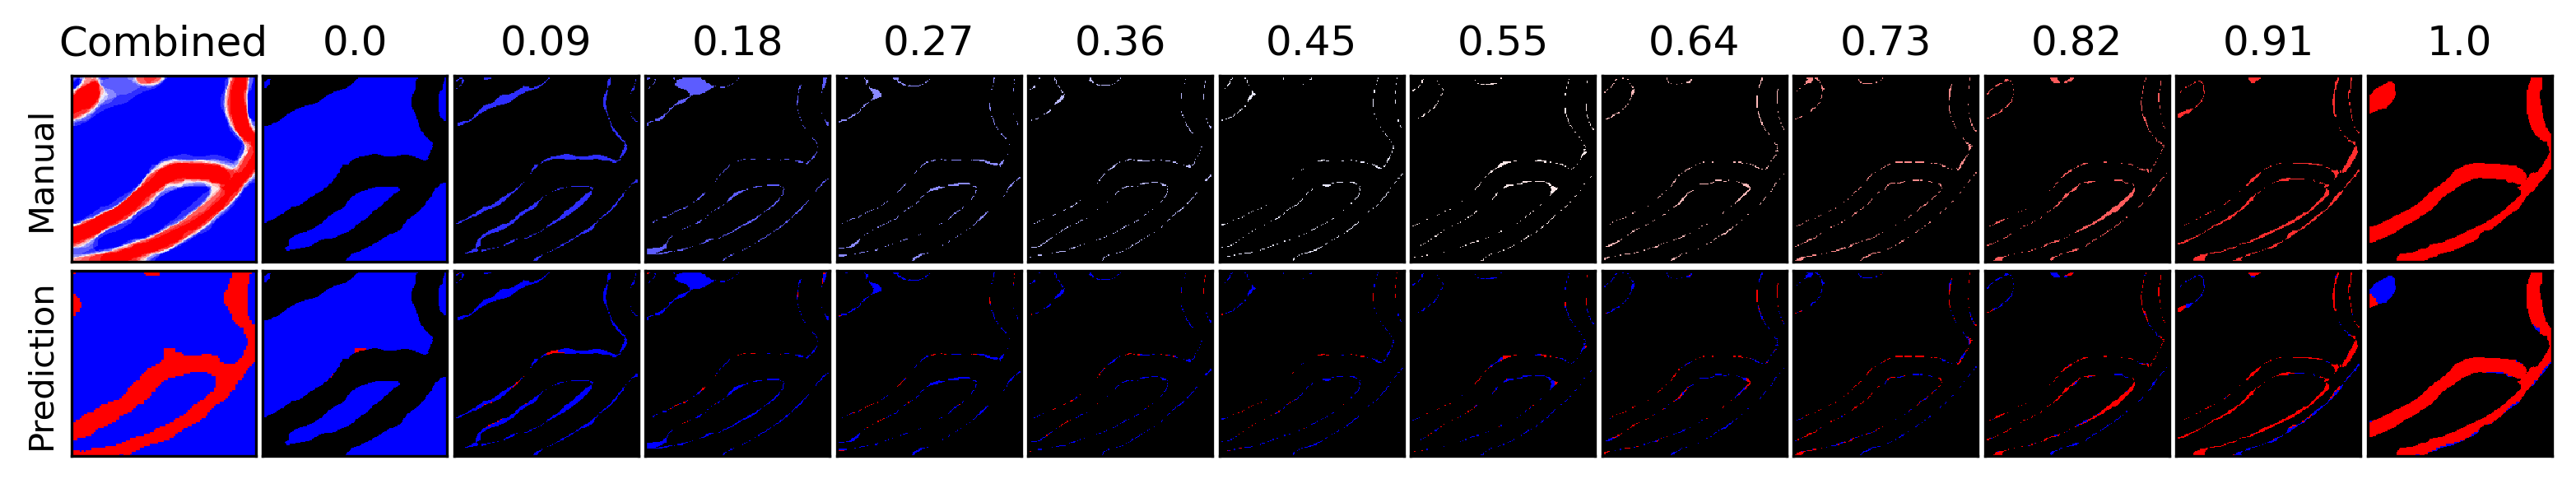

In [115]:
import tifffile
from collections import namedtuple
from annotator_metrics.util.doc_util import MaskInformation
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from annotator_metrics.src.preprocessing import follow_symlinks

def has_prediction(cell_name, organelle_name):
    pred_seg_path = "/groups/cellmap/cellmap/ackermand/forDavis/renumbered"
    is_lumen = False
    is_in = False

    has_prediction = True
    adjusted_name = organelle_name
    if "-lum" in adjusted_name:
        adjusted_name = adjusted_name.split("-lum")[0]
        is_lumen = True
    if "-in" in adjusted_name:
        adjusted_name = adjusted_name.split("in")[0]
        is_in = True

    path = f"{pred_seg_path}/{cell_name}/{cell_name}.n5/{adjusted_name}"
    if not os.path.exists(follow_symlinks(f"{path}_pred")):
        has_prediction = False
    elif is_lumen and not os.path.exists(
        follow_symlinks(f"{path}-mem_pred")
    ):
        # can only calculate lumen if we have a mem
        has_prediction = False
    elif is_in and not os.path.exists(
        follow_symlinks(f"{path}-out_pred")
    ):
        # can only calculate inner part if we have an outer part
        has_prediction = False
    return has_prediction

mi = MaskInformation()
FractionsTuple = namedtuple("FractionsTuple","annotator_fractions annotator_counts prediction_fractions")

row = mi.rows[0]
print(row.group, row.crop)
def get_positive_label_mask(image, organelle_label):
    if type(organelle_label) == list:
        positive_label_mask = np.zeros(image.shape, dtype=bool)
        for current_organelle_label in organelle_label:
            positive_label_mask |= image == current_organelle_label
    else:
        positive_label_mask = image == organelle_label
    return positive_label_mask


input_path = '/groups/cellmap/cellmap/ackermand/annotation_and_analytics/include_predictions/data'
image_names = os.listdir(f"{input_path}/{row.group}/{row.crop}")
images = []

# segmentations
for image_name in image_names:
    current_image = tifffile.imread(
        f"{input_path}/{row.group}/{row.crop}/{image_name}"
    )
    if "predictions" in image_name:
        prediction = current_image
    elif not any(s in image_name for s in ["ariadne", "refinements"]):
        images.append(current_image)


fraction_dict = {}
for organelle_name, organelle_label in row.organelle_info.items():
    if has_prediction(row.cell_name, organelle_name):
        organelle_images = []
        for image in images:
            organelle_images.append( get_positive_label_mask(image, organelle_label) )
        organelle_images = np.stack(tuple(organelle_images))
        fraction_positive = np.sum(organelle_images, axis=0)/organelle_images.shape[0]
        current_prediction = get_positive_label_mask(prediction, organelle_label)
        #treat annotator fractions as ground truth
        tp = np.sum(np.multiply(current_prediction,fraction_positive))
        fp = np.sum(np.multiply(current_prediction,1-fraction_positive))
        fn = np.sum(np.multiply(1-current_prediction, fraction_positive))

        dice = 2*tp/(2*tp + fp + fn)
        print(organelle_name, dice)
        annotator_fractions, annotator_counts = np.unique(fraction_positive, return_counts=True)
        prediction_fractions = []
        cmap = matplotlib.cm.bwr
        cmap.set_bad('black',1.)
        if organelle_name == "mito-mem":
            fraction_positive_to_keep=fraction_positive
            plt.rcParams['font.size'] = '10'
            fig, axs = plt.subplots(2, len(annotator_fractions)+1, figsize=(len(annotator_fractions)+1,2), dpi=300)
            axs[0,0].imshow(fraction_positive[:][:][20],interpolation="none",cmap=cmap,vmin=0,vmax=1)
            axs[1,0].imshow(current_prediction[:][:][20],interpolation="none",cmap=cmap,vmin=0,vmax=1)
            axs[0,0].set_xticks([])
            axs[0,0].set_yticks([])
            axs[1,0].set_xticks([])
            axs[1,0].set_yticks([])
            axs[0,0].set(title="Combined")
            axs[0,0].set(ylabel="Manual")
            axs[1,0].set(ylabel="Prediction")

            for i,fraction in enumerate(annotator_fractions):
                img = fraction_positive.copy()
                img_pred = current_prediction.copy().astype(np.float)
                img_pred[img!=fraction] = np.nan
                img[img!=fraction] = np.nan

                axs[0,i+1].imshow(img[:][:][20],interpolation='none',cmap=cmap,vmin=0,vmax=1)
                axs[1,i+1].imshow(img_pred[:][:][20],interpolation='none',cmap=cmap,vmin=0,vmax=1)
                axs[0,i+1].set(title=np.around(fraction*100)/100)
                axs[0,i+1].set_xticks([])
                axs[0,i+1].set_yticks([])
                axs[1,i+1].set_xticks([])
                axs[1,i+1].set_yticks([])
            fig.subplots_adjust(wspace=0, hspace=0.05)


        for fraction in annotator_fractions:
            prediction_fractions.append(current_prediction[fraction_positive == fraction].mean() )
            
        fraction_dict[organelle_name] = FractionsTuple(annotator_fractions,annotator_counts,prediction_fractions)
        print((np.sum(annotator_counts[:2])+np.sum(annotator_counts[-2:]))/np.sum(annotator_counts))


<Figure size 1920x1440 with 0 Axes>

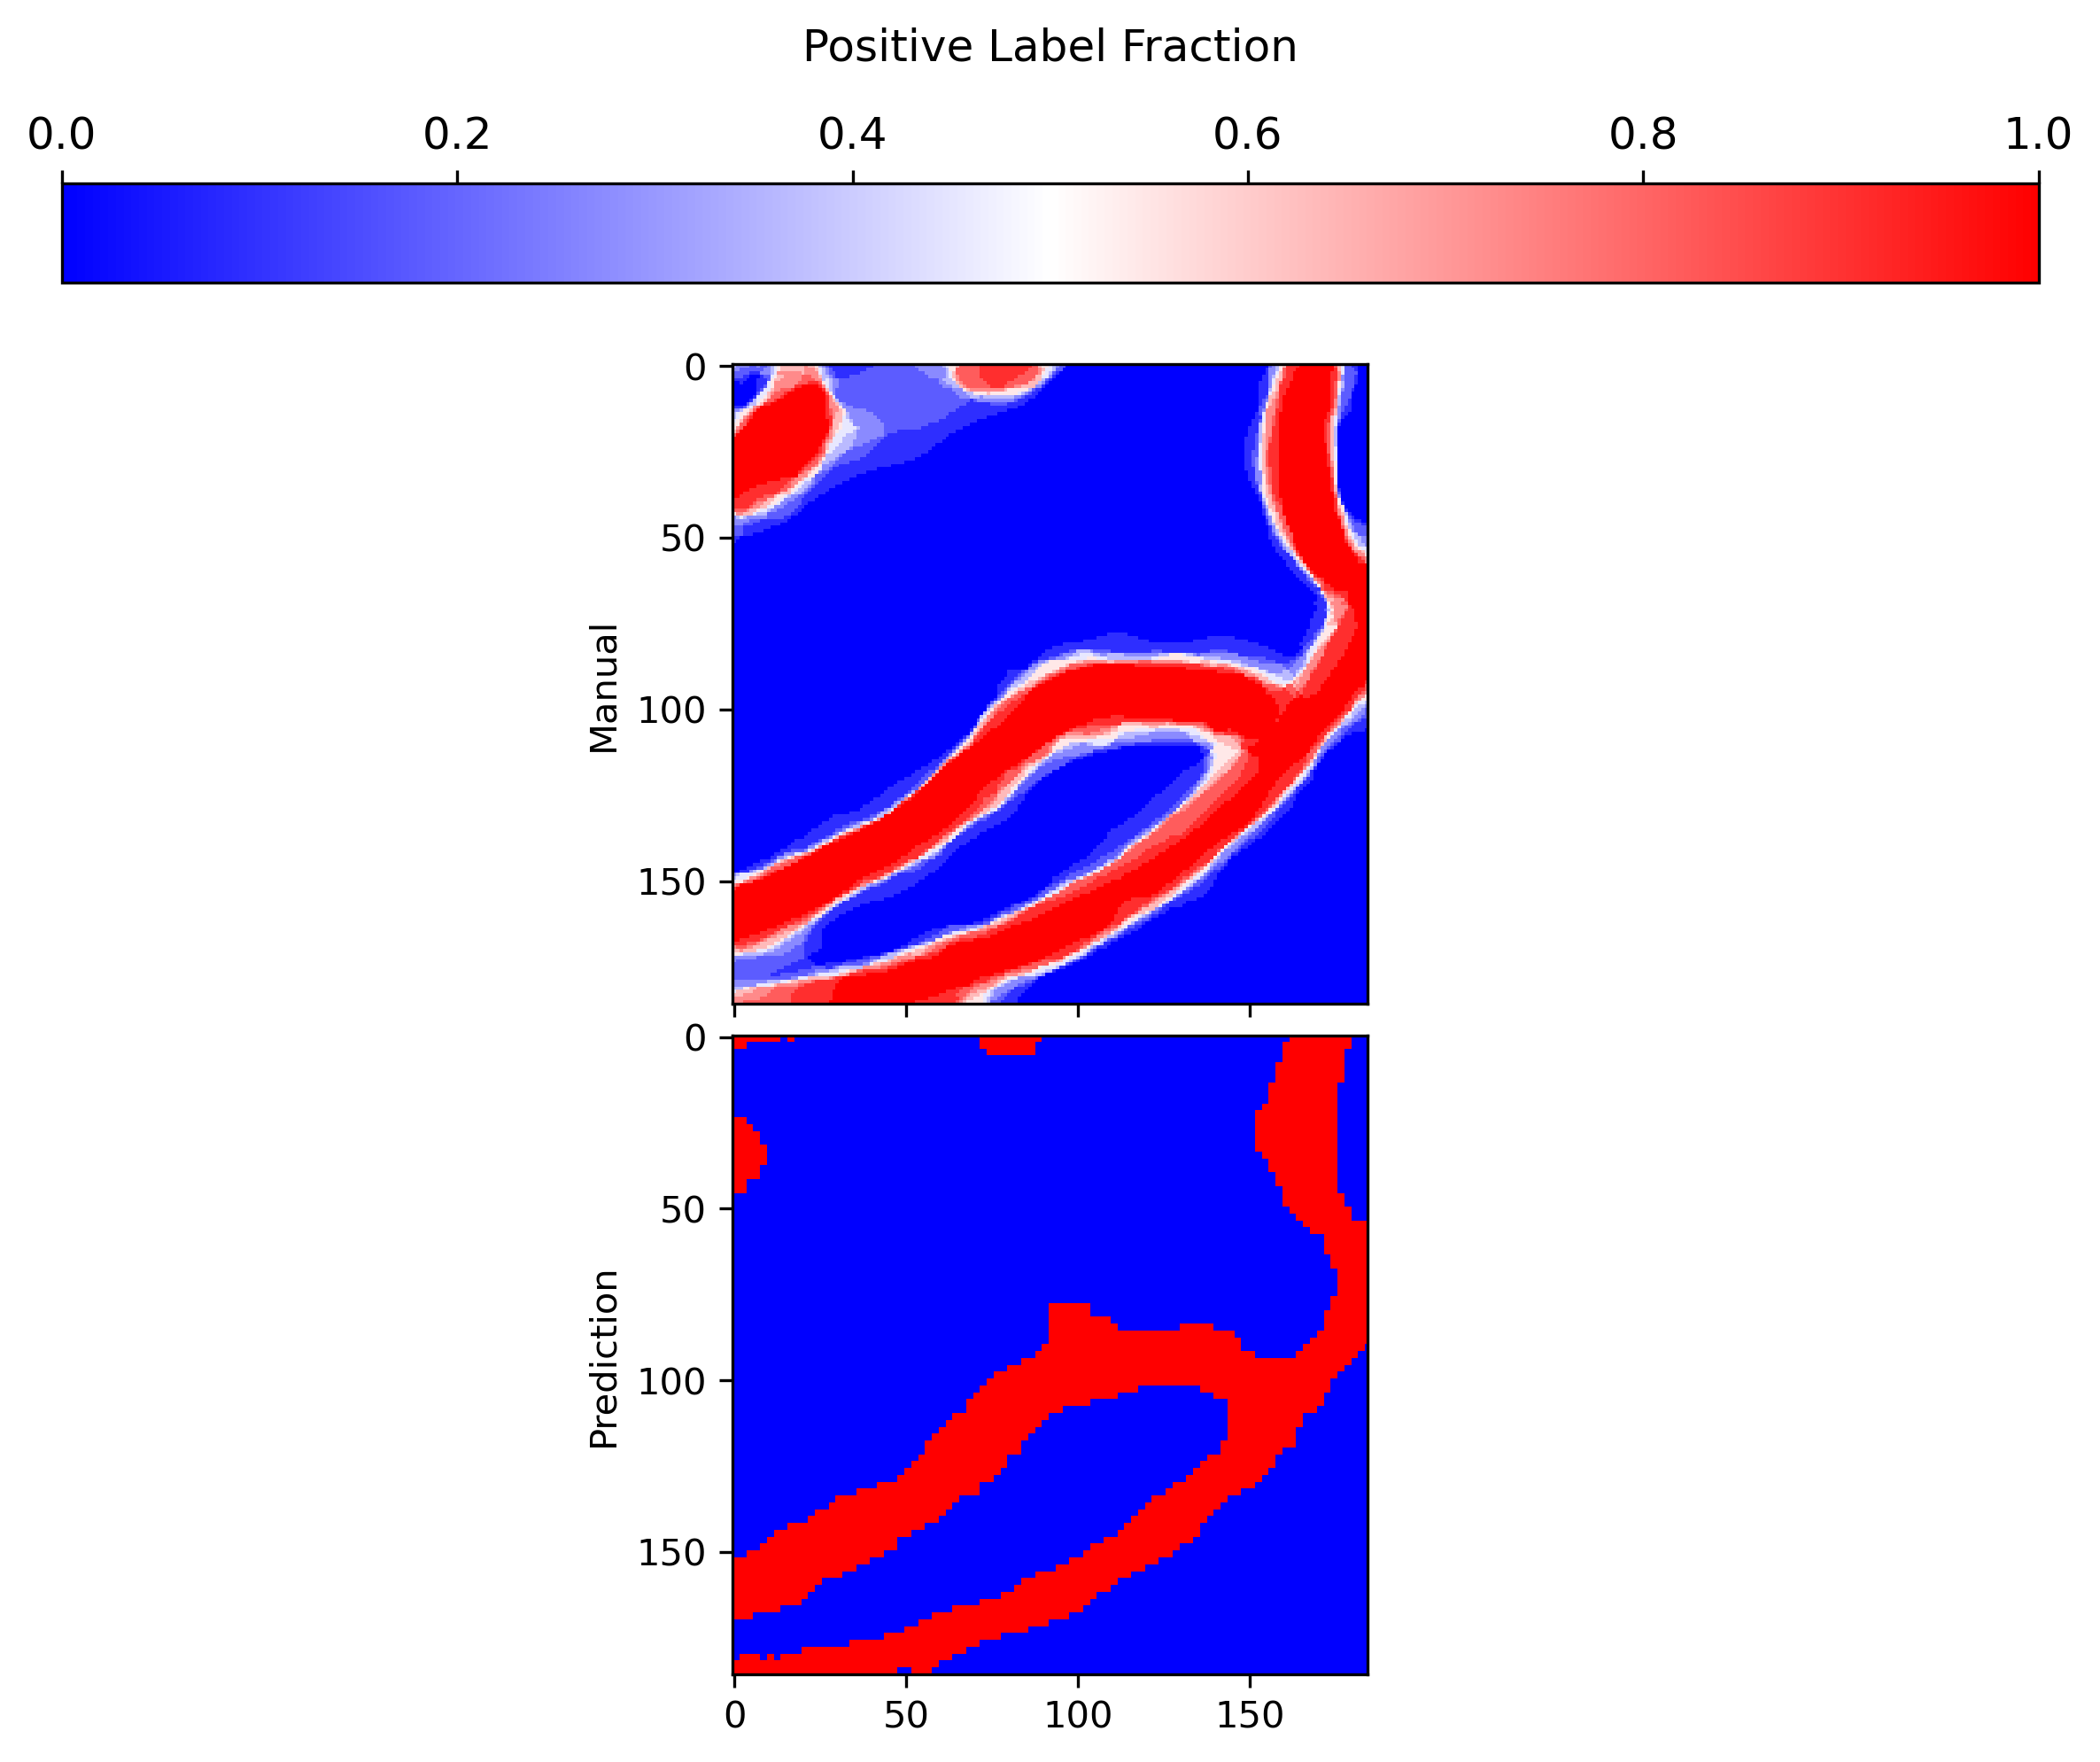

In [116]:
plt.figure(dpi=300)
fig, axs = plt.subplots(2, 1, figsize=(16,8), dpi=300,sharex=True)
plt.rcParams['font.size'] = '12'
axs[0].imshow(fraction_positive_to_keep[:][:][20],cmap=cmap,vmin=0,vmax=1,interpolation="none")
axs[0].set_ylabel("Manual")
tmp = axs[1].imshow(prediction[:][:][20]==3,cmap=cmap,vmin=0,vmax=1,interpolation="none")
axs[1].set_ylabel("Prediction")

#axs[0].title("mito-mem")
#cax = axs.axes([0.85, 0.1, 0.075, 0.8])
#cax = tmp.axes([0.85, 0.1, 0.075, 0.8])
fig.subplots_adjust(wspace=0, hspace=0.05)
cbar = fig.colorbar(tmp, ax=axs[:], shrink=0.6,location="top")
cbar.set_label('Positive Label Fraction', rotation=0,labelpad=15)


# Plot actual positive label fraction ratios

(-0.05, 1.05)

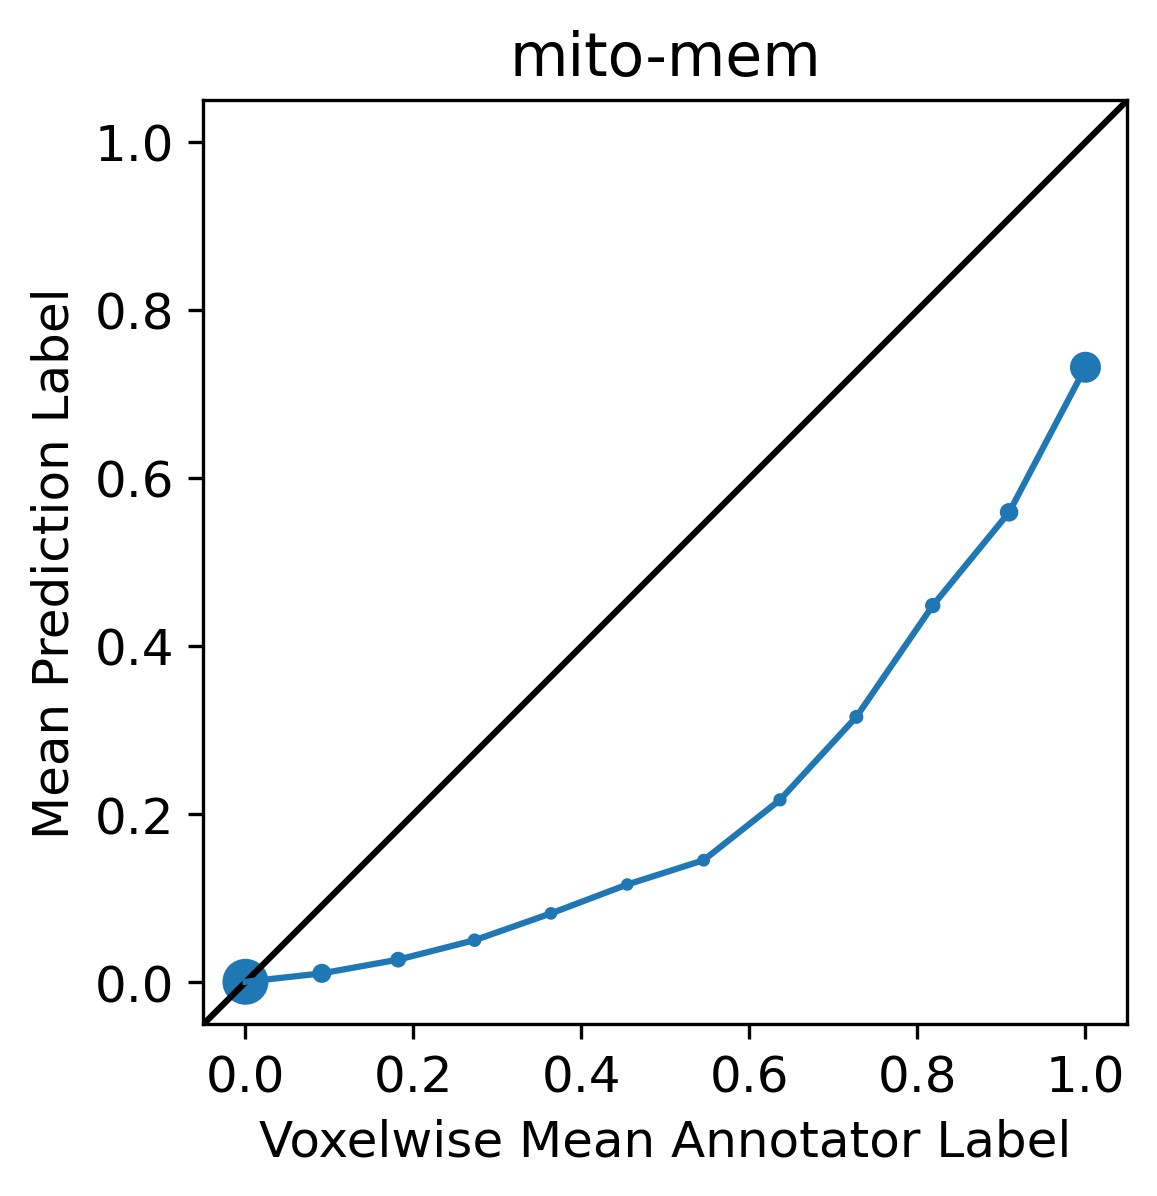

In [119]:
#plt.plot(fraction_tuple.annotator_fractions, fraction_tuple.prediction_fractions)
organelle_name = "mito-mem"
fraction_tuple = fraction_dict[organelle_name]
fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(111)
ax.set_aspect('equal')
plt.plot([-2,2], [-2,2],color="black")
plt.plot(fraction_tuple.annotator_fractions, fraction_tuple.prediction_fractions)
plt.scatter(fraction_tuple.annotator_fractions, fraction_tuple.prediction_fractions, s=4*fraction_tuple.annotator_counts/np.min(fraction_tuple.annotator_counts))
plt.title(organelle_name)
plt.xlabel("Voxelwise Mean Annotator Label")
plt.ylabel("Mean Prediction Label")
plt.xlim([-.05,1.05])
plt.ylim([-.05,1.05])

In [1]:
import tifffile
from collections import namedtuple
from annotator_metrics.util.doc_util import MaskInformation
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from annotator_metrics.src.preprocessing import follow_symlinks

def has_prediction(cell_name, organelle_name):
    pred_seg_path = "/groups/cellmap/cellmap/ackermand/forDavis/renumbered"
    is_lumen = False
    is_in = False

    has_prediction = True
    adjusted_name = organelle_name
    if "-lum" in adjusted_name:
        adjusted_name = adjusted_name.split("-lum")[0]
        is_lumen = True
    if "-in" in adjusted_name:
        adjusted_name = adjusted_name.split("-in")[0]
        is_in = True

    path = f"{pred_seg_path}/{cell_name}/{cell_name}.n5/{adjusted_name}"
    if not os.path.exists(follow_symlinks(f"{path}_pred")):
        has_prediction = False
    elif is_lumen and not os.path.exists(
        follow_symlinks(f"{path}-mem_pred")
    ):
        # can only calculate lumen if we have a mem
        has_prediction = False
    elif is_in and not os.path.exists(
        follow_symlinks(f"{path}-out_pred")
    ):
        # can only calculate inner part if we have an outer part
        has_prediction = False
    return has_prediction

def get_positive_label_mask(image, organelle_label):
    if type(organelle_label) == list:
        positive_label_mask = np.zeros(image.shape, dtype=bool)
        for current_organelle_label in organelle_label:
            positive_label_mask |= image == current_organelle_label
    else:
        positive_label_mask = image == organelle_label
    return positive_label_mask


input_path = '/groups/cellmap/cellmap/ackermand/annotation_and_analytics/include_predictions/data'

mi = MaskInformation()
default_counts_dict = {"annotator_counts":0, "prediction_counts":0}
organelle_dict = {}
for row in mi.rows:
    if row.group!="group7":
        prediction = None
        image_names = os.listdir(f"{input_path}/{row.group}/{row.crop}")
        images = []
        # segmentations
        for image_name in image_names:
            current_image = tifffile.imread(
                f"{input_path}/{row.group}/{row.crop}/{image_name}"
            )
            if "predictions" in image_name:
                prediction = current_image
            elif not any(s in image_name for s in ["ariadne", "refinements"]):
                images.append(current_image)


        for organelle_name, organelle_label in row.organelle_info.items():
            if has_prediction(row.cell_name, organelle_name):
                print(row.group, row.crop, organelle_name)
                organelle_images = []
                for image in images:
                    organelle_images.append( get_positive_label_mask(image, organelle_label) )
                organelle_images = np.stack(tuple(organelle_images))
                fraction_positive = np.sum(organelle_images, axis=0)/organelle_images.shape[0]
                current_prediction = get_positive_label_mask(prediction, organelle_label)

                annotator_fractions, annotator_counts = np.unique(fraction_positive, return_counts=True)
                #prediction_counts = []
                #prediction_fractions = []
                for idx,fraction in enumerate(annotator_fractions):
                    current_fraction_prediction = current_prediction[fraction_positive == fraction]
                    # prediction_counts.append(np.sum(current_fraction_prediction))
                    # prediction_fractions.append(current_prediction[fraction_positive == fraction].mean() )

                    if organelle_name not in organelle_dict:
                        organelle_dict[organelle_name] = {}
                        current_counts_dict = default_counts_dict.copy()
                    elif organelle_name in organelle_dict and fraction not in organelle_dict[organelle_name]:
                        # current organelle and fraction not present
                        current_counts_dict = default_counts_dict.copy()
                    else:
                        current_counts_dict = organelle_dict[organelle_name][fraction]
                    current_counts_dict["annotator_counts"] += annotator_counts[idx]
                    current_counts_dict["prediction_counts"] += current_fraction_prediction.sum()
                    organelle_dict[organelle_name][fraction] = current_counts_dict
display(organelle_dict)

group1 01 mito-mem
group1 01 mito-lumen
group1 01 mito
group1 02 mito-mem
group1 02 mito-lumen
group1 02 mito
group1 03 mito-mem
group1 03 mito-lumen
group1 03 mito
group1 04 mito-mem
group1 04 mito-lumen
group1 04 mito
group1 05 mito-mem
group1 05 mito-lumen
group1 05 mito
group1 08 mito-mem
group1 08 mito-lumen
group1 08 mito
group1 09 mito-mem
group1 09 mito-lumen
group1 09 mito
group1 10 mito-mem
group1 10 mito-lumen
group1 10 mito
group2 01 er-mem
group2 01 er-lum
group2 01 er
group2 01 eres
group2 02 er-mem
group2 02 er-lum
group2 02 er
group2 03 er-mem
group2 03 er-lum
group2 03 er
group2 03 eres
group2 04 er-mem
group2 04 er-lum
group2 04 er
group2 04 eres
group2 05 golgi-mem
group2 05 golgi-lum
group2 05 golgi
group2 06 er-mem
group2 06 er-lum
group2 06 golgi-mem
group2 06 golgi-lum
group2 06 er
group2 06 eres
group2 06 golgi
group3 01 pm
group3 02 pm
group3 03 pm
group3 04 pm
group3 04 vesicle-mem
group3 04 vesicle-lum
group3 04 vesicle
group3 05 pm
group3 05 vesicle-mem
grou

FileNotFoundError: [Errno 2] No such file or directory: '/groups/cellmap/cellmap/ackermand/annotation_and_analytics/include_predictions/data/group2/15'

Text(0, 0.5, 'Annotator Positive Label Fraction')

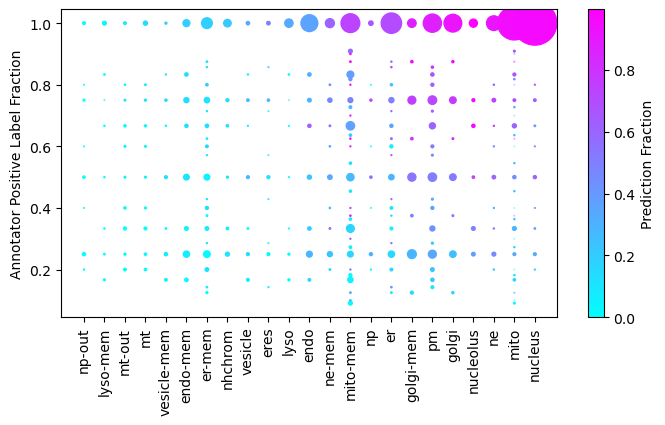

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
max_counts = -1
vmin = 10
vmax = -10
organelle_mean_dict = {}
for organelle, fraction_dict in organelle_dict.items():
    if "-in" not in organelle and "-lum" not in organelle:
        for annotator_fraction, counts_dict in fraction_dict.items():
            if annotator_fraction != 0:
                if counts_dict["annotator_counts"]>max_counts:
                    max_counts = counts_dict["annotator_counts"]
                delta = counts_dict["prediction_counts"]/counts_dict["annotator_counts"]
                if delta<vmin:
                    vmin = delta
                if delta>vmax:
                    vmax = delta
                if organelle not in organelle_mean_dict:
                    organelle_mean_dict[organelle] = {"delta_cum": 0, "count": 0}
                organelle_mean_dict[organelle]["delta_cum"] += delta * counts_dict["annotator_counts"]
                organelle_mean_dict[organelle]["count"] += counts_dict["annotator_counts"]
avgs = []
for organelle in organelle_mean_dict.keys():
    avgs.append(organelle_mean_dict[organelle]["delta_cum"]/organelle_mean_dict[organelle]["count"])
sorted_indices = np.argsort(avgs)
organelles = list(organelle_mean_dict.keys())
sorted_organelles = [organelles[s] for s in sorted_indices]

#for organelle, fraction_dict in organelle_dict.items():
for organelle in sorted_organelles:
    fraction_dict = organelle_dict[organelle]
    annotator_fractions = []
    prediction_fractions = []
    s = []
    if "-in" not in organelle and "-lum" not in organelle:
        for annotator_fraction, counts_dict in fraction_dict.items():
            if annotator_fraction != 0:
                annotator_fractions.append(annotator_fraction)
                prediction_fractions.append(counts_dict["prediction_counts"]/counts_dict["annotator_counts"])
                s.append(1000*counts_dict["annotator_counts"]/max_counts)
    plt.scatter([organelle]*len(annotator_fractions), annotator_fractions, s=s, c=prediction_fractions, cmap='cool',vmin=vmin,vmax=vmax)
c = plt.colorbar()
c.set_label("Prediction Fraction")
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.ylabel("Annotator Positive Label Fraction")

/groups/scicompsoft/home/ackermand/.local/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/groups/scicompsoft/home/ackermand/.local/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


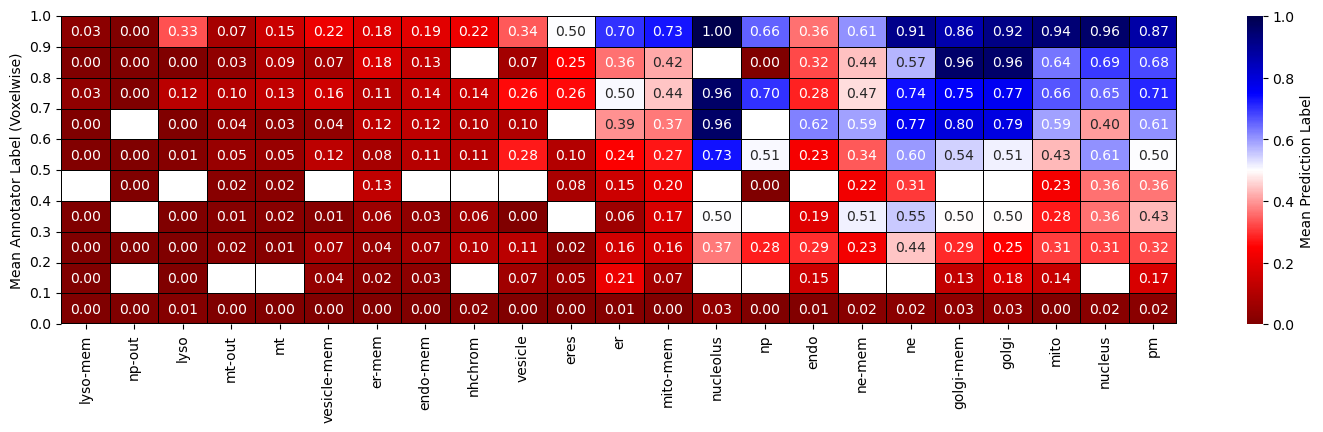

In [3]:
import matplotlib.pyplot as plt
import seaborn
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import ListedColormap

num_organelles = 0
organelle_names = []
num_bins = 10
do_basic_plot = True

for organelle, fraction_dict in organelle_dict.items():
    if "-in" not in organelle and "-lum" not in organelle:
        num_organelles += 1
        organelle_names.append(organelle)
heatmap_data_sum = np.zeros((num_bins,num_organelles)) # bin by 0.1
heatmap_data_counts = np.zeros((num_bins,num_organelles)) # bin by 0.1
delta_heatmap_data_sum = np.zeros((num_bins,num_organelles)) # bin by 0.1
delta_heatmap_data_counts = np.zeros((num_bins,num_organelles)) # bin by 0.1

organelle_idx = 0
for organelle, fraction_dict in organelle_dict.items():
    if "-in" not in organelle and "-lum" not in organelle:
        for annotator_fraction, counts_dict in fraction_dict.items():
            prediction_fraction = counts_dict["prediction_counts"]/counts_dict["annotator_counts"]
            annotation_bin = int(np.minimum(np.floor(annotator_fraction/(1/num_bins)),num_bins-1))
            #heatmap_data_sum[annotation_bin, organelle_idx] += counts_dict["prediction_counts"]
            heatmap_data_sum[annotation_bin, organelle_idx] += counts_dict["prediction_counts"]
            heatmap_data_counts[annotation_bin, organelle_idx] += counts_dict["annotator_counts"]

            delta = (prediction_fraction - annotator_fraction)
            if delta>0:
                # above line y=x
                delta /= (1 - annotator_fraction)
            elif delta<0:
                # below line y=x
                delta /= annotator_fraction
            delta_heatmap_data_sum[annotation_bin, organelle_idx] += delta*counts_dict["annotator_counts"]
            # heatmap_data_sum[annotation_bin, organelle_idx] += delta*counts_dict["annotator_counts"]
            delta_heatmap_data_counts[annotation_bin, organelle_idx] += counts_dict["annotator_counts"]

        organelle_idx += 1
heatmap_data = heatmap_data_sum/heatmap_data_counts
delta_heatmap_data = delta_heatmap_data_sum/delta_heatmap_data_counts

#annotator_fractions = np.arange(0, 1, 1/num_bins)
#for i in range(heatmap_data.shape[0]):
#    heatmap_data[i,:] = (i/num_bins - heatmap_data[i,:])/np.maximum(np.abs(1-i/num_bins),np.abs(i/num_bins-1))
organelle_mean = np.nanmean(np.abs(delta_heatmap_data),axis=0)
sorted_ids = np.argsort(organelle_mean)[::-1]
organelle_names = [organelle_names[s] for s in sorted_ids]
fig = plt.figure(figsize=(18,4))

if do_basic_plot:
    heatmap_data_to_plot = heatmap_data
    divnorm=colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax = 1)#vmin=np.nanmin(heatmap_data), vcenter=0., vmax=np.nanmax(heatmap_data))
else:
    heatmap_data_to_plot = delta_heatmap_data
    divnorm=colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax = 1)#vmin=np.nanmin(heatmap_data), vcenter=0., vmax=np.nanmax(heatmap_data))
heatmap_data_to_plot = heatmap_data_to_plot[:,sorted_ids]
heatmap_data_to_plot = heatmap_data_to_plot[::-1,:]

ax= seaborn.heatmap(
            heatmap_data_to_plot,
            annot=True,
            #square=True,
            linewidths = 0.5,
            linecolor = "black",
            fmt = ".2f",
            #vmin=0.775,#score_range_min,
            #max=all_to_all[mask].max(),#score_range_max,
            cmap="seismic_r",#"cool",
            norm = divnorm
        )
plt.xticks(
            [i + 0.5 for i in range(len(organelle_names))],
            organelle_names,
            rotation=90,
            #ha="left",
        )
plt.yticks(
    [i for i in range(num_bins+1)],
    [np.round((1-i*(1/num_bins))*10)/10 for i in range(num_bins+1)],
    rotation=0,
)
ax.axhline(10, linestyle='-', color='k') # horizontal lines
ax.axvline(23, linestyle='-', color='k') # horizontal lines

if do_basic_plot:
    plt.ylabel("Mean Annotator Label (Voxelwise)")
    ax.collections[0].colorbar.set_label("Mean Prediction Label")
else:
    plt.ylabel("Voxelwise Mean Annotator Label")
    ax.collections[0].colorbar.set_label("Normalized Prediction Performance")

#plt.ylim([10.05,0])
#plt.xlim([0,1])
#plt.xlim([0,1])




In [177]:

import json
import numpy as np
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
from IPython.display import display
keypoint_connections=[[0,1],
[0,15],
[0,16],
[15,17],
[16,18],
[1,5],
[5,6],
[6,7],
[1,2],
[2,3],
[3,4],
[1,8],
[8,9],
[9,10],
[10,11],
[11,24],
[11,22],
[22,23],
[8,12],
[12,13],
[13,14],
[14,21],
[14,19],
[19,20]
]

frame_jsons = [json.load(open(f"output/{p}")) for p in sorted(os.listdir("output/"))]
num_frames = len(frame_jsons)
total_runners = 8
valid_frame = 165
valid_json = frame_jsons[valid_frame]
valid_frame_person_order = list(range(8))
all_frames_person_order = [valid_frame_person_order]*num_frames
valid_frame_keypoints = []
for idx,person in enumerate(valid_json["people"]):
    keypoints = person["pose_keypoints_2d"]
    keypoints = np.array(person["pose_keypoints_2d"]).reshape((25,3))
    #keypoints = keypoints[keypoints[:,2]>0]
    valid_frame_keypoints.append(keypoints)

def get_people_order(all_frames_person_order, ranger):
    previous_keypoints = valid_frame_keypoints
    for frame_idx in ranger:
        frame_json = frame_jsons[frame_idx]
        current_keypoints = []
        for person in frame_json["people"]:
            keypoints = np.array(person["pose_keypoints_2d"]).reshape((25,3))
            current_keypoints.append(np.array(keypoints))

        current_frame_person_order = []
        current_frame_person_dist = []
        for idx,previous_keypoint in enumerate(previous_keypoints):
            valid_keypoints = previous_keypoint
            dists = []
            for current_keypoint in current_keypoints:
                valid_keypoints = (current_keypoint[:,2]>0) & (previous_keypoint[:,2]>0)
                delta = current_keypoint[valid_keypoints,:2] - previous_keypoint[valid_keypoints,:2]
                print(delta)
                dist = np.sum(np.sum(np.abs(delta)**2,axis=-1)**(1./2))
                dists.append(dist)
            dists = np.array(dists)
            current_dist = np.min(dists)
            closest_person_idx = np.argmin(dists)
            if closest_person_idx not in current_frame_person_order:
                current_frame_person_order.append(closest_person_idx)
                current_frame_person_dist.append(current_dist)
            else:
                #then two coms close to this point, but can only be one
                previous_dist = current_frame_person_dist[current_frame_person_order.index(closest_person_idx)]
                if current_dist < previous_dist:
                    # remove previous
                    current_frame_person_order[current_frame_person_order.index(closest_person_idx)] = -1
                    current_frame_person_order.append(closest_person_idx)
                    current_frame_person_dist.append(current_dist)
                else:
                    current_frame_person_order.append(-1)
                    current_frame_person_dist.append(current_dist)

        for idx in range(len(previous_keypoints)):
            if current_frame_person_order[idx]>=0:
                previous_keypoints[idx] = current_keypoints[current_frame_person_order[idx]]
        all_frames_person_order[frame_idx] = current_frame_person_order

get_people_order(all_frames_person_order, range(valid_frame-1,-1,-1))
get_people_order(all_frames_person_order, range(valid_frame+1,num_frames,1))



@widgets.interact(t=(0, len(frame_jsons)-1))
def display_frame(t):
    color_by_person = True
    current_json = frame_jsons[t]
    people = current_json["people"]
    for person_idx in all_frames_person_order[t]:
        if person_idx == -1:
            plt.gca()._get_lines.get_next_color()
        else:
            person = people[person_idx]
            plt.ylim([1000,200])
            plt.xlim([0, 1600])
            keypoints = np.array(person["pose_keypoints_2d"]).reshape((25,3))
            if color_by_person:
                color = plt.gca()._get_lines.get_next_color()
                for keypoint_connection in keypoint_connections:
                    if not (keypoints[keypoint_connection[0],2] == 0 or keypoints[keypoint_connection[1],2] == 0):
                        plt.plot(keypoints[keypoint_connection,0],keypoints[keypoint_connection,1],color=color)
                valid_keypoints = keypoints[keypoints[:,2]>0]
                plt.plot(np.mean(valid_keypoints[:,0]),np.mean(valid_keypoints[:,1]),'o',color=color)
            else:
                plt.gca().set_prop_cycle(None)
                for keypoint_connection in keypoint_connections:
                    if not (keypoints[keypoint_connection[0],2] == 0 or keypoints[keypoint_connection[1],2] == 0):
                        plt.plot(keypoints[keypoint_connection,0],keypoints[keypoint_connection,1])
                    else:
                        plt.gca()._get_lines.get_next_color()


# Collect data for thicknesses by running medial surface thinning on all data
# THIS TAKES A LONG TIME

In [1]:
from annotator_metrics.util.doc_util import MaskInformation
from annotator_metrics.src.preprocessing import get_resolution_and_offset_from_zarr
import zarr
from numcodecs.gzip import GZip
import numpy as np
import subprocess
import time
import shutil
import os

def get_failed_jobs_info_from_spark(failed_jobs):
    failed_jobs_info = []
    for failed_job in failed_jobs:
        with open(f"/groups/scicompsoft/home/ackermand/.spark/{failed_job}", "r") as file:
            first_line = file.readline().split("--inputN5Path ")[1].split(" --outputN5DatasetSuffix")[0]
            group = first_line.split("/")[-2]
            crop = first_line.split("/")[-1].split(".n5")[0]
            dataset = first_line.split("--inputN5DatasetName ")[-1]
            failed_jobs_info.append(f"{group}_{crop}_{dataset}")
    return failed_jobs_info

def get_failed_organelles(path = '/groups/cellmap/cellmap/ackermand/annotation_and_analytics/annotator_thickness'):
    failed_organelles = []
    for group in os.listdir(path):
        group_path = path + "/" + group
        for crop in os.listdir(group_path):
            crop_path = group_path + "/" + crop
            for organelle in os.listdir(crop_path):
                if "medialSurface" not in organelle and "attributes" not in organelle:
                    if not os.path.isdir(crop_path+"/"+organelle+"_medialSurface"):
                        crop = crop.split(".n5")[0]
                        failed_organelles.append(f"{group}_{crop}_{organelle}")
    return failed_organelles
        

def build_toplogical_thinning_command(thickness_path, dataset):
    # after failed, change N_EXECUTORS_PER_NODE from 1 to 5
    command = f"""ssh login1 << \ENDSSH
    JAR=/groups/scicompsoft/home/ackermand/Programming/cosem-segmentation-analysis/target/cosem-segmentation-analysis-0.0.1-SNAPSHOT.jar

    FLINTSTONE=/groups/flyTEM/flyTEM/render/spark/spark-janelia/flintstone.sh
    CLASS=org.janelia.cosem.analysis.SparkTopologicalThinning
    N_NODES=1

    export LSF_PROJECT=cellmap
    export N_CORES_DRIVER=1
    export N_EXECUTORS_PER_NODE=5
    export N_CORES_PER_EXECUTOR=1
    export RUNTIME="48:00"
    export JAVA_HOME="/usr/lib/jvm/java-1.8.0"
    ARGV="\
    --inputN5Path {thickness_path} \
    --inputN5DatasetName {dataset} \
    --outputN5DatasetSuffix '_medialSurface' \
    --doMedialSurface\
    "
    TERMINATE=1 $FLINTSTONE $N_NODES $JAR $CLASS $ARGV
    ENDSSH"""
    return command

failed_organelles = get_failed_organelles()
mi = MaskInformation()
for row in mi.rows:
    if row.group != "group7" and row.group == "group5" and (row.crop=="13" or row.crop=="14" or row.crop=="15"):
        n5 = f'/groups/cellmap/cellmap/ackermand/annotation_and_analytics/include_predictions/results/n5s/{row.group}/{row.crop}.n5'
        zarr_file = zarr.open(n5, mode="r")
        for dataset in os.listdir(n5):
            if dataset not in ["raw","attributes.json"] and "variance" not in dataset:
                resolution, offset = get_resolution_and_offset_from_zarr(
                    zarr_file[dataset]
                )
                image = zarr_file[dataset][:][:][:]
                organelle_info = row.organelle_info
                thickness_path = f'/groups/cellmap/cellmap/ackermand/annotation_and_analytics/annotator_thickness/{row.group}/{row.crop}.n5'
                store = zarr.N5Store(thickness_path)
                zarr_root = zarr.group(store=store)
                for organelle_name, organelle_label in organelle_info.items():
                    #if f"{row.group}_{row.crop}_{dataset}_{organelle_name}" in failed_jobs_info or row.group=="full_crop":
                    #if f"{row.group}_{row.crop}_{dataset}_{organelle_name}" in failed_organelles:
                        if os.path.exists(f"{thickness_path}/{dataset}_{organelle_name}"):
                            shutil.rmtree(f"{thickness_path}/{dataset}_{organelle_name}")
                        print(row.group, row.crop, dataset, organelle_name)
                        current_image = np.zeros(image.shape, dtype=np.uint8)
                        if type(organelle_label)!=list:
                            organelle_label = [organelle_label]
                        for current_label in organelle_label:
                            current_image |= image==current_label
                        ds = zarr_root.create_dataset(
                                name=f'{dataset}_{organelle_name}',
                                data=current_image.astype(np.uint8),
                                shape=current_image.shape,
                                chunks=128,
                                write_empty_chunks=True,
                                compressor=GZip(level=6),
                            )
                        attributes = ds.attrs
                        attributes["pixelResolution"] = {
                            "dimensions": 3 * [row.correct_resolution],
                            "unit": "nm",
                        }
                        time.sleep(2)
                        cmd = build_toplogical_thinning_command(thickness_path, f"{dataset}_{organelle_name}")
                        subprocess.call(cmd, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)

group5 13 e1 ne-mem
group5 13 e1 ne-lum
group5 13 e1 nucleus
group5 13 e1 ne
group5 13 gt ne-mem
group5 13 gt ne-lum
group5 13 gt nucleus
group5 13 gt ne
group5 13 g1 ne-mem
group5 13 g1 ne-lum
group5 13 g1 nucleus
group5 13 g1 ne
group5 13 predictions ne-mem
group5 13 predictions ne-lum
group5 13 predictions nucleus
group5 13 predictions ne
group5 13 i1 ne-mem
group5 13 i1 ne-lum
group5 13 i1 nucleus
group5 13 i1 ne
group5 13 a1 ne-mem
group5 13 a1 ne-lum
group5 13 a1 nucleus
group5 13 a1 ne
group5 13 refinements ne-mem
group5 13 refinements ne-lum
group5 13 refinements nucleus
group5 13 refinements ne
group5 13 f1 ne-mem
group5 13 f1 ne-lum
group5 13 f1 nucleus
group5 13 f1 ne
group5 13 b1 ne-mem
group5 13 b1 ne-lum
group5 13 b1 nucleus
group5 13 b1 ne
group5 14 e1 ne-mem
group5 14 e1 ne-lum
group5 14 e1 nucleus
group5 14 e1 ne
group5 14 gt ne-mem
group5 14 gt ne-lum
group5 14 gt nucleus
group5 14 gt ne
group5 14 g1 ne-mem
group5 14 g1 ne-lum
group5 14 g1 nucleus
group5 14 g1 ne
grou

In [1]:
def get_failed_organelles(path = '/groups/cellmap/cellmap/ackermand/annotation_and_analytics/annotator_thickness'):
    failed_organelles = []
    for group in os.listdir(path):
        group_path = path + "/" + group
        for crop in os.listdir(group_path):
            crop_path = group_path + "/" + crop
            for organelle in os.listdir(crop_path):
                if "medialSurface" not in organelle and "attributes" not in organelle:
                    if not os.path.isdir(crop_path+"/"+organelle+"_medialSurface"):
                        crop = crop.split(".n5")[0]
                        failed_organelles.append(f"{group}_{crop}_{organelle}")
    return failed_organelles

print( get_failed_organelles() )


[]


# Plot histograms of thickness distributions for a few mito classes

In [ ]:
from scipy.ndimage.morphology import distance_transform_edt
import matplotlib.pyplot as plt

from annotator_metrics.util.doc_util import MaskInformation
from annotator_metrics.src.preprocessing import get_resolution_and_offset_from_zarr
import zarr
from numcodecs.gzip import GZip
import numpy as np
import subprocess
import time
import shutil
import csv


mi = MaskInformation()
    
    # create the csv writer
step = 10
idx=0
plt.rcParams['font.size'] = '14'
for row in mi.rows:
    control_image = None
    if row.group == "group1" and row.crop == "01":
        n5 = f'/groups/cellmap/cellmap/ackermand/annotation_and_analytics/include_predictions/results/n5s/{row.group}/{row.crop}.n5'
        zarr_file = zarr.open(n5, mode="r")
        organelle_info = row.organelle_info
        num_organelles = len(organelle_info)
        fig, axs = plt.subplots(num_organelles, 1, sharex=True, sharey=False, figsize=(7.5,10), dpi=300)
        for organelle_name, organelle_label in organelle_info.items():
            legend = []
            min_bin = 10000
            max_bin = -1
            for dataset in os.listdir(n5):
                if dataset not in ["raw","attributes.json","predictions","refinements"] and "variance" not in dataset:
                    resolution, offset = get_resolution_and_offset_from_zarr(
                        zarr_file[dataset]
                    )
                    thickness_path = f'/groups/cellmap/cellmap/ackermand/annotation_and_analytics/annotator_thickness/{row.group}/{row.crop}.n5'
                    store = zarr.N5Store(thickness_path)
                    zarr_root = zarr.group(store=store)
                    if f"{dataset}_{organelle_name}_medialSurface" in os.listdir(thickness_path):
                        current_image = zarr_root[f"{dataset}_{organelle_name}"][:][:][:]
                        current_image_medial_surface = zarr_root[f"{dataset}_{organelle_name}_medialSurface"][:][:][:]
                        if control_image is None:
                            control_image = np.pad(np.ones(current_image.shape),1,'constant',constant_values=0)
                            control_image_edt = distance_transform_edt(control_image)
                        current_image = np.pad(current_image, 1, 'constant', constant_values=0)
                        current_image_medial_surface = np.pad(current_image_medial_surface, 1, 'constant', constant_values=0)
                        current_image_edt = distance_transform_edt(current_image)
                        current_image_edt[(current_image_edt>=control_image_edt) | (current_image_medial_surface==0)] = np.NaN
                        current_image_edt*=resolution*2 #times two to get thickness
                        #plt.figure()
                        vals, bins = np.histogram(current_image_edt[~np.isnan(current_image_edt)], bins=np.arange(start=0, stop=1001, step=step))#, density=True)
                        nonzeros = vals.nonzero()[0]
                        if len(nonzeros)>0:
                            min_bin = min(min_bin, bins[nonzeros[0]])
                            max_bin = max(max_bin, bins[nonzeros[-1]])
                        color = next(axs[idx]._get_lines.prop_cycler)['color']
                        axs[idx].plot(np.arange(step/2, 1000, step), vals, color=color)
                        #axs[idx].axvline(x = np.nanmean(current_image_edt), color=color, label = 'axvline - full height',linewidth=0.75, zorder=0)
                        print(row.group,row.crop,dataset,organelle_name,np.nanmean(current_image_edt),np.nanmedian(current_image_edt),np.nanstd(current_image_edt))
                        legend.append(dataset)
                        legend.append("_")
            axs[idx].set_ylabel(f"{organelle_name} Counts")
            axs[idx].set_xlim(min_bin-step,max_bin+step)
            #axs[idx].legend(legend)
            idx+=1
axs[2].set_xlabel(f"Thickness (nm)")
plt.subplots_adjust(wspace=0.05, hspace=0.05)


# Collect thickness data for all organelles into my-thicknesses.csv. This also takes a while

In [2]:
from scipy.ndimage.morphology import distance_transform_edt
import matplotlib.pyplot as plt

from annotator_metrics.util.doc_util import MaskInformation
from annotator_metrics.src.preprocessing import get_resolution_and_offset_from_zarr
import zarr
from numcodecs.gzip import GZip
import numpy as np
import subprocess
import time
import shutil
import csv

mi = MaskInformation()
with open('my-thicknesses.csv', 'w') as f:
    
    # create the csv writer
    writer = csv.writer(f)
    writer.writerow(["group","crop","annotator","organelle","mean","median","std"])

    for row in mi.rows:
        control_image = None
        if row.group != "group7":
            n5 = f'/groups/cellmap/cellmap/ackermand/annotation_and_analytics/include_predictions/results/n5s/{row.group}/{row.crop}.n5'
            zarr_file = zarr.open(n5, mode="r")
            for dataset in os.listdir(n5):
                if dataset not in ["raw","attributes.json"] and "variance" not in dataset:
                    resolution, offset = get_resolution_and_offset_from_zarr(
                        zarr_file[dataset]
                    )
                    organelle_info = row.organelle_info
                    thickness_path = f'/groups/cellmap/cellmap/ackermand/annotation_and_analytics/annotator_thickness/{row.group}/{row.crop}.n5'
                    store = zarr.N5Store(thickness_path)
                    zarr_root = zarr.group(store=store)
                    for organelle_name, organelle_label in organelle_info.items():
                        if f"{dataset}_{organelle_name}_medialSurface" in os.listdir(thickness_path):
                            current_image = zarr_root[f"{dataset}_{organelle_name}"][:][:][:]
                            current_image_medial_surface = zarr_root[f"{dataset}_{organelle_name}_medialSurface"][:][:][:]
                            if control_image is None:
                                control_image = np.pad(np.ones(current_image.shape),1,'constant',constant_values=0)
                                control_image_edt = distance_transform_edt(control_image)
                            current_image = np.pad(current_image, 1, 'constant', constant_values=0)
                            current_image_medial_surface = np.pad(current_image_medial_surface, 1, 'constant', constant_values=0)
                            current_image_edt = distance_transform_edt(current_image)
                            current_image_edt[(current_image_edt>=control_image_edt) | (current_image_medial_surface==0)] = np.NaN
                            current_image_edt*=resolution*2 #times two to get thickness
                            #plt.figure()
                            print(row.group,row.crop,dataset,organelle_name,np.nanmean(current_image_edt),np.nanmedian(current_image_edt),np.nanstd(current_image_edt))
                            writer.writerow([row.group,row.crop,dataset,organelle_name,np.nanmean(current_image_edt),np.nanmedian(current_image_edt),np.nanstd(current_image_edt)])
                        #plt.imshow(current_image_edt[:][:][50], interpolation='none')   

group1 01 e1 mito-mem 31.266155732032125 32.2490309931942 8.370111604116415
group1 01 e1 mito-lumen 37.45176880957369 34.40930106817051 22.66441778174219
group1 01 e1 mito 47.19656818193491 44.181444068749045 13.728945766080123
group1 01 gt mito-mem 28.653746391164987 28.0 9.455246473614576
group1 01 gt mito-lumen 47.38919723981168 45.60701700396552 25.749187963224962


/groups/scicompsoft/home/ackermand/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
/groups/scicompsoft/home/ackermand/miniconda3/envs/annotator-metrics/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/groups/scicompsoft/home/ackermand/miniconda3/envs/annotator-metrics/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/groups/scicompsoft/home/ackermand/.local/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice


group1 01 gt mito nan nan nan
group1 01 a2 mito-mem 34.73502693223352 34.17601498127012 6.865419153159215
group1 01 a2 mito-lumen 48.46815057351209 49.47726750741192 19.980928196815352
group1 01 a2 mito nan nan nan
group1 01 g1 mito-mem 34.01030246277149 34.87119154832539 8.888737453025874
group1 01 g1 mito-lumen 42.802524387546704 41.182520563948 22.265232138389695
group1 01 g1 mito 82.35166057981088 75.25955088890711 42.00949677114682
group1 01 i1 mito-mem 48.27578695305391 48.98979485566356 11.331853269748406
group1 01 i1 mito-lumen 40.250032207053565 38.57460304397182 17.42045835895121
group1 01 i1 mito nan nan nan
group1 01 a1 mito-mem 39.42938905801592 38.57460304397182 9.030881282625861
group1 01 a1 mito-lumen 50.37331159609067 50.91168824543142 19.986895795672496
group1 01 a1 mito nan nan nan
group1 01 d1 mito-mem 33.41678697405755 33.94112549695428 7.653854611156548
group1 01 d1 mito-lumen 40.825395656903126 36.4417343165772 22.3363150009262
group1 01 d1 mito nan nan nan
group

# Thickness vs Thickness plots for annotator-to-annotators

In [3]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
df = pandas.read_csv("my-thicknesses.csv")
columns = ['annotator_one','mean_one', 'std_one','annotator_two','mean_two','std_two','group_crop','organelle']
comparison_dictionary = {}
comparison_df = pd.DataFrame(columns=columns)

i = 0
for idx1 in range(df.shape[0]):
    row1 = df.iloc[idx1]
    print(idx1)
    for idx2 in range(idx1,df.shape[0]):
        row2 = df.iloc[idx2]
        if row1["group"] == row2["group"] and row1["crop"] == row2["crop"] and row1["organelle"]==row2["organelle"] and row1["annotator"] != row2["annotator"] and "mem" in row1["organelle"]:
            comparison_dictionary[i] = dict(zip(columns, [row1["annotator"],row1['mean'],row1['std'],row2["annotator"],row2['mean'],row2['std'],f'{row1["group"]}_{row1["crop"]}',row1["organelle"]]))
            comparison_dictionary[i+1] = dict(zip(columns, [row2["annotator"],row2['mean'],row2['std'],row1["annotator"],row1['mean'],row1['std'],f'{row1["group"]}_{row1["crop"]}',row1["organelle"]]))
            i+=2
comparison_df = DataFrame.from_dict(comparison_dictionary, "index")
# plt.plot( pandas.thickness) )
print(comparison_df)
plt.plot(comparison_df["mean_one"],comparison_df["mean_two"])

NameError: name 'pandas' is not defined

# Make box and whiskers plots for all organelles using my-thicknesses.csv

In [4]:
import plotly.express as px
import plotly.graph_objects as go
import pandas 
df = pandas.read_csv("my-thicknesses.csv")
fig = go.Figure(layout = go.Layout(yaxis=dict(title="Thickness (nm)")) )
annotator_df = df.loc[(df['annotator'] != "predictions") & (df['annotator'] != "refinements") & (df['annotator'] != "ariadne") ]
automated_df = df.loc[(df['annotator'] == "predictions")]
annotator_df = annotator_df[~(annotator_df["organelle"].str.contains('lum')) & ~(annotator_df["organelle"].str.contains('in'))]

sorted_df = annotator_df[["organelle","mean"]].groupby('organelle').median().sort_values(by=['mean'])
fig.add_traces(go.Box(x=annotator_df["organelle"],y=annotator_df["mean"]))
#fig.add_traces(px.strip(automated_df, x="organelle",y="mean", stripmode = 'overlay',color_discrete_sequence=["black"]).data)

fig.update_xaxes(categoryorder='array', categoryarray= sorted_df.index)
fig.update_yaxes(type='log',tickformat = ".1r")
fig.update_layout(showlegend=False)


# Images showing slice of all-to-all matrix

In [ ]:
import matplotlib.pyplot as plt
import zarr
import numpy as np
n5 = f'/groups/cellmap/cellmap/ackermand/annotation_and_analytics/include_predictions/results/n5s/group1/01.n5'
zarr_file = zarr.open(n5, mode="r")
datasets = ["a1","a2","b1","b2","c1","d1","e1","f1","g1","i1","gt"]
fig, ax = plt.subplots(len(datasets)+1,len(datasets)+1,figsize=(6, 6), dpi=300,facecolor="white")
plt.suptitle('mito-mem')
for i, dataset_one in enumerate(datasets):
    i+=1
    red = (zarr_file[dataset_one][:][:][20]==3)*1.0 #membrane
    green = np.zeros(red.shape)
    if dataset_one == "gt":
        dataset_one = "j1"
    ax[i][0].set_ylabel(dataset_one)
    ax[i][0].yaxis.label.set_color('red')
    ax[i][0].imshow(np.dstack((red,green,green)),interpolation='none')
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])
    for j,dataset_two in enumerate(datasets):
        j+=1
        blue = (zarr_file[dataset_two][:][:][20]==3)*1.0 #membrane
        img = np.dstack((red,blue,green))
        ax[i][j].imshow(img,interpolation='none')
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        if i==1:
            if dataset_two == "gt":
                dataset_two = "j1"
            ax[0][j].set_title(dataset_two,color="green")
            ax[0][j].imshow(np.dstack((green,blue,green)),interpolation='none')
            ax[0][j].set_xticks([])
            ax[0][j].set_yticks([])

ax[0][0].axis('off')

# Consolodate stuff for Alyson, how old is this. Was this what is being used?

In [ ]:
# for alyson, how old is this
import pandas as pd
import os
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

def consolidate_csvs(dir, metric_name, organelle, skip_duplicates=True, skip_selfself=True):
    output_df = None
    print(organelle)
    for group in os.listdir(dir):
        for crop in os.listdir(f"{dir}/{group}/"):
            file_path = f"{dir}/{group}/{crop}/{metric_name}/{organelle}.csv"
            if os.path.exists(file_path):
                current_df = pd.read_csv(file_path)
                if skip_duplicates or skip_selfself: 
                    rows_to_drop = []
                    pairs = []
                    for i, row in current_df.iterrows():
                        if skip_duplicates and (row["annotator 2"],row["annotator 1"]) in pairs:
                            rows_to_drop.append(i)
                        if skip_selfself and row["annotator 1"] == row["annotator 2"]:
                            rows_to_drop.append(i)
                        if row["annotator 1"] in ["refinements","ariadne"] or row["annotator 2"] in ["refinements","ariadne"]:
                            rows_to_drop.append(i)
                        pairs.append((row["annotator 1"],row["annotator 2"]))
                        if row["annotator 2"]=="predictions":
                            current_df.iloc[i] = [row["annotator 2"],row["annotator 1"], row[current_df.columns[2]]]
                    current_df = current_df.drop(rows_to_drop)                    
                if output_df is None:
                    output_df = current_df
                else:
                    output_df = output_df.append(current_df)
    
    output_df["organelle"] = organelle

    annotator_df = output_df[(output_df["annotator 1"]!="predictions") & (output_df["annotator 2"]!="predictions")]
    predictions_df = output_df[(output_df["annotator 1"] == "predictions") | (output_df["annotator 2"]=="predictions")]
    
    annotator_df["type"] = "manual"
    predictions_df["type"] = "prediction"

    output_df = annotator_df
    output_df = output_df.append(predictions_df)
    return output_df

dir = "/groups/cellmap/cellmap/ackermand/annotation_and_analytics/include_predictions/results/csvs"

all_organelles = [
    "mito",
    "er",
    "mito-mem",
    "pm",
    "nucleus",
    "endo",
    "er-mem",
    "golgi",
    "golgi-mem",
    "endo-mem",
    "lyso",
    "mt",
    #"nucleus-mem",
    "ne",
    "mt-out",
    "vesicle",
    #"ld",
    "ne-mem",
    "vesicle-mem",
    "lyso-mem",
    "eres",
    #"ld-mem",
    "eres-mem",
    "nuclear-pore-out",
    "nuclear-pore-in"
]

scores = ["dice","mean_false_bdy_distance","false_positive_rate","false_negative_rate"]
for score in scores:
    all_organelle_df = None
    for organelle in all_organelles:
        output_df = consolidate_csvs(dir, score, organelle)
        if all_organelle_df is None:
            all_organelle_df = output_df
        else:
            all_organelle_df = all_organelle_df.append(output_df)

    all_organelle_df.to_csv(f"my-presentation-stuff/summary-{score}.csv", index=False)
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(rc={"figure.dpi":300, 'savefig.dpi':300, 'figure.figsize':(15,5)})

# sns.set(style="whitegrid")
# tips = sns.load_dataset("tips")


# ax = sns.boxplot(x="organelle", y=all_organelle_df[all_organelle_df.columns[2]], data=all_organelle_df, showfliers = False, hue="type")
# ax = sns.stripplot(x="organelle", y=all_organelle_df[all_organelle_df.columns[2]], data=all_organelle_df, color=".25", s=2, hue="type",dodge=True)
# plt.xticks(rotation=45,ha="right")
# plt.show()

# Plot thicknesses fraction as a function of annotator

Text(0.5, 1.0, 'mt-out')

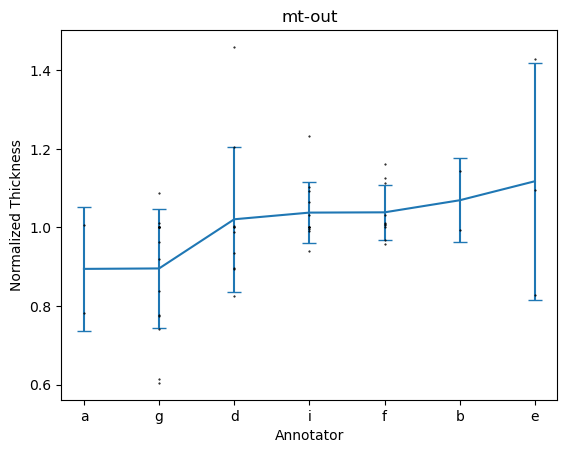

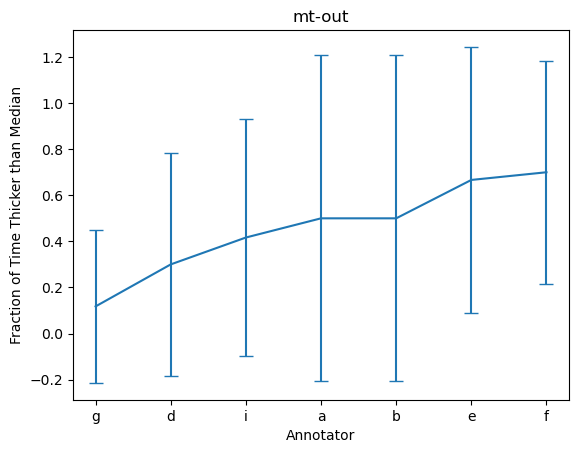

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("my-thicknesses.csv")
organelle = "mt-out"
df = df[ df["organelle"].str.contains(organelle)]
df = df[ ~df["annotator"].isin(["predictions", "refinements", "ariadne"]) ]
df['annotator'] = df['annotator'].map(lambda x: x[0])
df = df.replace("gt","y1")

df['average median'] = df.groupby(['group','crop','organelle'])["mean"].transform('median')
df['ratio'] = df['mean']/df['average median']
df['greater than median'] = df['mean'] > df['average median']

# plot ratios
ratio_mean = df.groupby(['annotator'])['ratio'].mean()
ratio_std = df.groupby(['annotator'])['ratio'].std()
sorted_indices = ratio_mean.sort_values().index
plt.figure()
plt.errorbar(x=sorted_indices, y=ratio_mean[sorted_indices], yerr=ratio_std[sorted_indices], capsize=5)
plt.xlabel("Annotator")
plt.ylabel("Normalized Thickness")
plt.title(organelle)
with_points = True
if with_points:
    plt.plot(df['annotator'],df['ratio'],'.',markersize=1,color='black')

# plot fraction of time greater than median
gtm_mean = df.groupby(['annotator'])['greater than median'].mean()
gtm_std = df.groupby(['annotator'])['greater than median'].std()
sorted_indices = gtm_mean.sort_values().index
plt.figure()
plt.errorbar(x=sorted_indices, y=gtm_mean[sorted_indices], yerr=gtm_std[sorted_indices], capsize=5)
plt.xlabel("Annotator")
plt.ylabel("Fraction of Time Thicker than Median")
plt.title(organelle)

